## Imports

In [120]:

import inspect
import os
import sys
# os.chdir('../')
# print(os.getcwd())
# if "experimental_copy_redo" in str(os.getcwd()):
#     os.chdir('../')
"""
    IMPORTING LIBS
"""
import dgl

import numpy as np
import os
import socket
import time
import random
import glob
import argparse, json
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader

from tensorboardX import SummaryWriter
from tqdm import tqdm

import random
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp

import pandas as pd

import dgl.function as fn
MODEL_NAME = 'GraphSage'

class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

"""
    IMPORTING CUSTOM MODULES/METHODS
"""
# from nets.COLLAB_edge_classification.load_net import gnn_model # import all GNNS
from nets.COLLAB_edge_classification.load_net import gnn_model
from data.data import LoadData
"""
    GPU Setup
"""
def gpu_setup(use_gpu, gpu_id):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)  

    if torch.cuda.is_available() and use_gpu:
#         print('cuda available with GPU:',torch.cuda.get_device_name(0))
        device = torch.device("cuda")
    else:
#         print('cuda not available')
        device = torch.device("cpu")
    return device
use_gpu = False; gpu_id = -1; device = None # CPU
# """
#     USER CONTROLS
# """

## Load Data

In [121]:
from NewDataset_for_ranking import NewDataset
def load_datset(DATASET_NAME):
    print("[I] Loading data (notebook) ...")
    parts = DATASET_NAME.split("--")
    APPLICATION_NAME = parts[1]
    # dataset = LoadData(DATASET_NAME)
    dataset = NewDataset(APPLICATION_NAME)
    print("[I] Finished loading.....")
    return dataset

## DEFINE PARAMETER

In [122]:

def define_parameter(MODEL_NAME, dataset):
    
#     MODEL_NAME = 'MF'
    # MODEL_NAME = 'GatedGCN'
    
    n_heads = -1
    edge_feat = False
    pseudo_dim_MoNet = -1
    kernel = -1
    gnn_per_block = -1
    embedding_dim = -1
    pool_ratio = -1
    n_mlp_GIN = -1
    gated = False
    self_loop = False
    max_time = 12
    layer_type = 'dgl'
    num_embs = -1
    pos_enc = True
    #pos_enc = False
    pos_enc_dim = 10

    
    if MODEL_NAME == 'MF':
        seed=41; epochs=500; batch_size=32*1024; init_lr=0.01; lr_reduce_factor=0.5; lr_schedule_patience=10; min_lr = 1e-5; weight_decay=0
        L=0; hidden_dim=256; out_dim=hidden_dim; num_embs=235868;
    
    if MODEL_NAME == 'MLP':
        seed=41; epochs=500; batch_size=32*1024; init_lr=0.001; lr_reduce_factor=0.5; lr_schedule_patience=10; min_lr = 1e-5; weight_decay=0
        L=3; hidden_dim=80; out_dim=hidden_dim; dropout=0.0; readout='mean'; gated = False  # Change gated = True for Gated MLP model
    
    if MODEL_NAME == 'GCN':
        seed=41; epochs=500; batch_size=32*1024; init_lr=0.001; lr_reduce_factor=0.5; lr_schedule_patience=10; min_lr = 1e-5; weight_decay=0
        L=5; hidden_dim=74; out_dim=hidden_dim; dropout=0.0; readout='mean';
        
    if MODEL_NAME == 'GraphSage':
        seed=41; epochs=500; batch_size=32*1024; init_lr=0.001; lr_reduce_factor=0.5; lr_schedule_patience=10; min_lr = 1e-5; weight_decay=0
        L=10; hidden_dim=38; out_dim=hidden_dim; dropout=0.0; readout='mean'; layer_type='edgefeat'

    if MODEL_NAME == 'GAT':
        seed=41; epochs=500; batch_size=32*1024; init_lr=0.001; lr_reduce_factor=0.5; lr_schedule_patience=10; min_lr = 1e-5; weight_decay=0
        L=3; n_heads=3; hidden_dim=19; out_dim=n_heads*hidden_dim; dropout=0.0; readout='mean'; layer_type='dgl'
    
    if MODEL_NAME == 'GIN':
        seed=41; epochs=500; batch_size=32*1024; init_lr=0.001; lr_reduce_factor=0.5; lr_schedule_patience=10; min_lr = 1e-5; weight_decay=0
        L=3; hidden_dim=60; out_dim=hidden_dim; dropout=0.0; readout='mean';
        
    if MODEL_NAME == 'MoNet':
        seed=41; epochs=500; batch_size=32*1024; init_lr=0.001; lr_reduce_factor=0.5; lr_schedule_patience=10; min_lr = 1e-5; weight_decay=0
        L=3; hidden_dim=53; out_dim=hidden_dim; dropout=0.0; readout='mean';
        
    if MODEL_NAME == 'GatedGCN':
        seed=41; epochs=500; batch_size=32*1024; init_lr=0.001; lr_reduce_factor=0.5; lr_schedule_patience=10; min_lr = 1e-5; weight_decay=0
        L=5; hidden_dim=35; out_dim=hidden_dim; dropout=0.0; readout='mean'; edge_feat = False; layer_type='edgereprfeat'
        
    # generic new_params
    net_params = {}
    net_params['device'] = device
    net_params['in_dim'] = dataset.graph.ndata['feat'].shape[-1]
    net_params['in_dim_edge'] = dataset.graph.edata['feat'].shape[-1]
    net_params['residual'] = True
    net_params['hidden_dim'] = hidden_dim
    net_params['out_dim'] = out_dim
    num_classes = 1
    net_params['n_classes'] = num_classes
    net_params['n_heads'] = n_heads
    net_params['L'] = L  # min L should be 2
    net_params['readout'] = "mean"
    net_params['layer_norm'] = True
    net_params['batch_norm'] = True
    net_params['in_feat_dropout'] = 0.0
    net_params['dropout'] = 0.0
    net_params['edge_feat'] = edge_feat
    net_params['self_loop'] = self_loop
    net_params['layer_type'] = layer_type
    
    # for MF
    net_params['num_embs'] = num_embs
    
    # for MLPNet 
    net_params['gated'] = gated
    
    # specific for MoNet
    net_params['pseudo_dim_MoNet'] = 2
    net_params['kernel'] = 3
    
    # specific for GIN
    net_params['n_mlp_GIN'] = 2
    net_params['learn_eps_GIN'] = True
    net_params['neighbor_aggr_GIN'] = 'sum'
    
    # specific for graphsage
    net_params['sage_aggregator'] = 'maxpool'   
    
    # specific for pos_enc_dim
    net_params['pos_enc'] = pos_enc
    net_params['pos_enc_dim'] = pos_enc_dim

    
    params = {}
    params['seed'] = seed
    params['epochs'] = epochs
    params['batch_size'] = batch_size
    params['init_lr'] = init_lr
    params['lr_reduce_factor'] = lr_reduce_factor 
    params['lr_schedule_patience'] = lr_schedule_patience
    params['min_lr'] = min_lr
    params['weight_decay'] = weight_decay
    params['print_epoch_interval'] = 5
    params['max_time'] = max_time

    return net_params, params
    


## Load Data

In [123]:
def LoadDF(APPLICATION_NAME):
    df = pd.read_csv("../prune_new/"+APPLICATION_NAME+"_node.csv")
    return df  

## DEFINE PARAMETER

In [124]:
def define_parameter(MODEL_NAME, dataset):
    
#     MODEL_NAME = 'MF'
    # MODEL_NAME = 'GatedGCN'
    
    n_heads = -1
    edge_feat = False
    pseudo_dim_MoNet = -1
    kernel = -1
    gnn_per_block = -1
    embedding_dim = -1
    pool_ratio = -1
    n_mlp_GIN = -1
    gated = False
    self_loop = False
    max_time = 12
    layer_type = 'dgl'
    num_embs = -1
    pos_enc = True
    #pos_enc = False
    pos_enc_dim = 10

    
    if MODEL_NAME == 'MF':
        seed=41; epochs=500; batch_size=32*1024; init_lr=0.01; lr_reduce_factor=0.5; lr_schedule_patience=10; min_lr = 1e-5; weight_decay=0
        L=0; hidden_dim=256; out_dim=hidden_dim; num_embs=235868;
    
    if MODEL_NAME == 'MLP':
        seed=41; epochs=500; batch_size=32*1024; init_lr=0.001; lr_reduce_factor=0.5; lr_schedule_patience=10; min_lr = 1e-5; weight_decay=0
        L=3; hidden_dim=80; out_dim=hidden_dim; dropout=0.0; readout='mean'; gated = False  # Change gated = True for Gated MLP model
    
    if MODEL_NAME == 'GCN':
        seed=41; epochs=500; batch_size=32*1024; init_lr=0.001; lr_reduce_factor=0.5; lr_schedule_patience=10; min_lr = 1e-5; weight_decay=0
        L=5; hidden_dim=74; out_dim=hidden_dim; dropout=0.0; readout='mean';
        
    if MODEL_NAME == 'GraphSage':
        seed=41; epochs=500; batch_size=32*1024; init_lr=0.001; lr_reduce_factor=0.5; lr_schedule_patience=10; min_lr = 1e-5; weight_decay=0
        L=10; hidden_dim=38; out_dim=hidden_dim; dropout=0.0; readout='mean'; layer_type='edgefeat'

    if MODEL_NAME == 'GAT':
        seed=41; epochs=500; batch_size=32*1024; init_lr=0.001; lr_reduce_factor=0.5; lr_schedule_patience=10; min_lr = 1e-5; weight_decay=0
        L=3; n_heads=3; hidden_dim=19; out_dim=n_heads*hidden_dim; dropout=0.0; readout='mean'; layer_type='dgl'
    
    if MODEL_NAME == 'GIN':
        seed=41; epochs=500; batch_size=32*1024; init_lr=0.001; lr_reduce_factor=0.5; lr_schedule_patience=10; min_lr = 1e-5; weight_decay=0
        L=3; hidden_dim=60; out_dim=hidden_dim; dropout=0.0; readout='mean';
        
    if MODEL_NAME == 'MoNet':
        seed=41; epochs=500; batch_size=32*1024; init_lr=0.001; lr_reduce_factor=0.5; lr_schedule_patience=10; min_lr = 1e-5; weight_decay=0
        L=3; hidden_dim=53; out_dim=hidden_dim; dropout=0.0; readout='mean';
        
    if MODEL_NAME == 'GatedGCN':
        seed=41; epochs=500; batch_size=32*1024; init_lr=0.001; lr_reduce_factor=0.5; lr_schedule_patience=10; min_lr = 1e-5; weight_decay=0
        L=5; hidden_dim=35; out_dim=hidden_dim; dropout=0.0; readout='mean'; edge_feat = False; layer_type='edgereprfeat'
        
    # generic new_params
    net_params = {}
    net_params['device'] = device
    net_params['in_dim'] = dataset.graph.ndata['feat'].shape[-1]
    net_params['in_dim_edge'] = dataset.graph.edata['feat'].shape[-1]
    net_params['residual'] = True
    net_params['hidden_dim'] = hidden_dim
    net_params['out_dim'] = out_dim
    num_classes = 1
    net_params['n_classes'] = num_classes
    net_params['n_heads'] = n_heads
    net_params['L'] = L  # min L should be 2
    net_params['readout'] = "mean"
    net_params['layer_norm'] = True
    net_params['batch_norm'] = True
    net_params['in_feat_dropout'] = 0.0
    net_params['dropout'] = 0.0
    net_params['edge_feat'] = edge_feat
    net_params['self_loop'] = self_loop
    net_params['layer_type'] = layer_type
    
    # for MF
    net_params['num_embs'] = num_embs
    
    # for MLPNet 
    net_params['gated'] = gated
    
    # specific for MoNet
    net_params['pseudo_dim_MoNet'] = 2
    net_params['kernel'] = 3
    
    # specific for GIN
    net_params['n_mlp_GIN'] = 2
    net_params['learn_eps_GIN'] = True
    net_params['neighbor_aggr_GIN'] = 'sum'
    
    # specific for graphsage
    net_params['sage_aggregator'] = 'maxpool'   
    
    # specific for pos_enc_dim
    net_params['pos_enc'] = pos_enc
    net_params['pos_enc_dim'] = pos_enc_dim

    
    params = {}
    params['seed'] = seed
    params['epochs'] = epochs
    params['batch_size'] = batch_size
    params['init_lr'] = init_lr
    params['lr_reduce_factor'] = lr_reduce_factor 
    params['lr_schedule_patience'] = lr_schedule_patience
    params['min_lr'] = min_lr
    params['weight_decay'] = weight_decay
    params['print_epoch_interval'] = 5
    params['max_time'] = max_time

    return net_params, params
    


## VIEW MODEL PARAMETER

In [125]:

def view_model_param(MODEL_NAME, net_params):
    # print(net_params)
    model = gnn_model(MODEL_NAME, net_params)
    total_param = 0
    # print("MODEL DETAILS:\n")
    # print(model)
    for param in model.parameters():
        # print(param.data.size())
        total_param += np.prod(list(param.data.size()))
    # print('MODEL/Total parameters:', MODEL_NAME, total_param)
    return total_param

tim1 = time.time()


## Set Parameters

In [126]:
def set_parameters(MODEL_NAME, dataset, DATASET_NAME):
    net_params, params = define_parameter(MODEL_NAME=MODEL_NAME, dataset=dataset)
    config = {}
    gpu = {}
    gpu['use'] = use_gpu
    gpu['id'] = gpu_id
    config['gpu'] = gpu
    # GNN model, dataset, out_dir
    config['model'] = MODEL_NAME
    config['dataset'] = DATASET_NAME
    out_dir = 'out/debug/'
    config['out_dir'] = out_dir
    config['params'] = params
    # network parameters
    config['net_params'] = net_params
    params = config['params']
    DATASET_NAME = config['dataset']
    device = gpu_setup(config['gpu']['use'], config['gpu']['id'])
    out_dir = config['out_dir']
    MODEL_NAME = config['model']
    net_params = config['net_params']
    net_params['device'] = device
    net_params['gpu_id'] = config['gpu']['id']
    net_params['batch_size'] = params['batch_size']
    net_params['in_dim'] = dataset.graph.ndata['feat'].shape[-1]
    net_params['in_dim_edge'] = dataset.graph.edata['feat'].shape[-1]
    net_params['n_classes'] = 1  # binary prediction
    net_params['total_param'] = view_model_param(MODEL_NAME, net_params)
    
    return net_params, params

## Get Epoc Number

In [127]:
def get_EPOC_Number(PATH):
    file_path = PATH+"/ROC_CURVE/*"
    project_list = glob.glob(file_path)
    max_ = -1
    for line in project_list:
        index = line.rfind("_")
        last_index = line.rfind(".png")
        number = int(line[index+1:last_index])
        max_ = max(max_, number)
    # print(max_)
    return max_

## Train Model

In [128]:
def train_model(dataset, EPOC_NUMBER, APPLICATION_NAME, net_params, params, MODEL_NAME):
    t0 = time.time()    
    DATASET_NAME = dataset.name

    if MODEL_NAME in ['GatedGCN']:
        if net_params['pos_enc']:
#             print("[!] Adding graph positional encoding",net_params['pos_enc_dim'])
            dataset._add_positional_encodings(net_params['pos_enc_dim'])
#             print('Time PE:',time.time()-t0)

    graph = dataset.graph
    evaluator=""
    train_edges, val_edges, val_edges_neg, test_edges, test_edges_neg = dataset.train_edges, dataset.val_edges, dataset.val_edges_neg, dataset.test_edges, dataset.test_edges_neg
    device = net_params['device']
    random.seed(params['seed'])
    np.random.seed(params['seed'])
    torch.manual_seed(params['seed'])
    if device.type == 'cuda':
        torch.cuda.manual_seed(params['seed'])

#     print("Graph: ", graph)
#     print("Training Edges: ", len(train_edges))
#     print("Validation Edges: ", len(val_edges) + len(val_edges_neg))
#     print("Test Edges: ", len(test_edges) + len(test_edges_neg))

#     print(net_params)
    model = gnn_model(MODEL_NAME, net_params)
    model = model.to(device)
    out_dir = 'out/debug/'
    PATH = out_dir + 'checkpoints/' + MODEL_NAME + "_NEW_DATASET--" + APPLICATION_NAME + "/RUN_/epoch_"+str(EPOC_NUMBER)+".pkl"
    t = torch.load(PATH)
    model.load_state_dict(torch.load(PATH))
#     print(model)

    optimizer = optim.Adam(model.parameters(), lr=params['init_lr'], weight_decay=params['weight_decay'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                        factor=params['lr_reduce_factor'],
                                                        patience=params['lr_schedule_patience'],
                                                        verbose=True)

    return model, graph

## Get Test Data

In [129]:
def get_random_test_data(src_id,test_size, APPLICATION_NAME=""):
    ROOT_PATH = "../prune_new/"
    df = pd.read_csv(ROOT_PATH+ APPLICATION_NAME+'_node.csv')
    nodes_data = df.drop(["start_line","start_column","end_line",  "end_column" ,"file_name"], axis=1)
    
    stmt_type=['FunctionDeclaration', 'ArrowFunctionExpression', 'FunctionExpression']
    df1 = nodes_data[nodes_data.type.isin(stmt_type)]
    test_neg_id = df1['new_id'].tolist()

    df1 = nodes_data[((nodes_data['type']=='CallExpression')|(nodes_data['type']=='NewExpression'))]
    test_neg_call_site = df1['new_id'].tolist()

    test_edges= pd.read_csv(ROOT_PATH+ APPLICATION_NAME +'_function_edges.csv')

    test_edges.columns = ["src", "dst"]
    index = pd.MultiIndex.from_product([test_neg_call_site, test_neg_id], names = ["src", "dst"])
    all_combi = pd.DataFrame(index = index).reset_index()
    
    test_neg_df =  pd.merge(all_combi,test_edges, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
    test_neg_df = test_neg_df.iloc[np.random.permutation(len(test_neg_df))]
    test_neg_df = test_neg_df[test_neg_df['src']==src_id]
    test_neg_df = test_neg_df[:test_size]
    test_edges = torch.from_numpy(test_neg_df.to_numpy())
    return test_edges
#     return test_neg_df

In [130]:
# def get_test_data(src_id, for_true_negative=False, APPLICATION_NAME=""):
#     # print(src_id)
#     ROOT_PATH = "../prune_new/"
#     df = pd.read_csv(ROOT_PATH+ APPLICATION_NAME+'_node.csv')
#     d = dict()
#     f = open('../connected_files/'+APPLICATION_NAME+'_dependency_graph.json')
#     data = json.load(f)
#     u=[]
#     v=[]
#     temp_df_src = df[df['new_id']==src_id]
#     file_name = temp_df_src.iloc[0]['file_name']
#     new_lst = []
#     new_lst.append(file_name)
#     try:
#         lst = data[file_name]
#         for x in lst:
#             if "lodash/internal" in x:
#                 x = x.replace("lodash/internal","lodash/.internal")
#             new_lst.append(x)
#     except:
#         pass
    
#     # for x in lst:
#     #     if "lodash/internal" in x:
#     #         x = x.replace("lodash/internal","lodash/.internal")
#     #     new_lst.append(x)
#     # print(new_lst)
#     stmt_type=['FunctionDeclaration', 'ArrowFunctionExpression', 'FunctionExpression']
#     dst_df = df[(df.type.isin(stmt_type)) & (df.file_name.isin(new_lst))]
#     if for_true_negative:
#         return dst_df
#     # print(dst_df['file_name'])
#     # print(file_name, "====>",  len(dst_df))
#     test_neg_id = dst_df['new_id'].tolist()
#     done_list={}
#     for node in test_neg_id:
#         if (src_id,node) not in done_list:
#                 u.append(src_id)
#                 v.append(node)
#                 done_list[(src_id,node)]=True

#     d={'src':u, 'dst':v}
#     test_df = pd.DataFrame(d)
# #     print(test_df)
#     test_edges = torch.from_numpy(test_df.to_numpy())
#     # random_test_edge = get_random_test_data(src_id,1000, APPLICATION_NAME)
#     return test_edges, random_test_edge

In [131]:
def get_test_data(file_name, src_id, APPLICATION_NAME):
    # print(src_id)
    f = open('candidate_edge_files/'+APPLICATION_NAME+'_candidate_edges.json')
    data = json.load(f)
    u=[]
    v=[]
    test_neg_id = data[file_name]
    done_list={}
    for node in test_neg_id:
        if (src_id,node) not in done_list:
                u.append(src_id)
                v.append(node)
                done_list[(src_id,node)]=True

    d={'src':u, 'dst':v}
    test_df = pd.DataFrame(d)
    test_edges = torch.from_numpy(test_df.to_numpy())
    random_test_edge={}
    return test_edges, random_test_edge

## Get Cutoff Threshold

In [132]:
def get_thresholds(PATH, EPOC_NUMBER):
    all_list =[[],[],[]]
    k=0
    with open(PATH+"/THRESHOLD/threshold_values_with_"+str(EPOC_NUMBER)+".txt") as in_file:
        for line in in_file:
            parts = line.split(" ")
            # print(parts)
            for part in parts:
                try:
                    numeric_string = float(''.join(c for c in part if (c.isdigit() or c =='.' or c=='e' or c=='-')))
                    # print(numeric_string)
                    all_list[k].append(numeric_string)
                except:
                    pass
            if "]" in line:
                k+=1

    threshold_lst = all_list[0]
    fpr_lst = all_list[1]
    tpr_lst = all_list[2]

    # print(threshold_lst)
    for i in range(len(fpr_lst)):
        if fpr_lst[i]>=0.05:
            first_index = i-1
            break
    
    # print(first_index)
    first_thrshld = threshold_lst[first_index]

    return first_thrshld


In [133]:
# APPLICATION_NAME = 'express'
# PATH = "results/NEW_DATASET--"+APPLICATION_NAME+"/"+MODEL_NAME
# EPOC_NUMBER = get_EPOC_Number(PATH=PATH)
# print(EPOC_NUMBER)
# print(get_thresholds(PATH=PATH, EPOC_NUMBER=EPOC_NUMBER))


## Evaluate Network

In [134]:
def evaluate_network(model, device, graph, test_edges,
                     batch_size, DATASET_NAME="", MODEL_NAME="", SOURCE_NODE=0, DST_NODE=0, APPLICATION_NAME="", EPOC_NUMBER=0, TARGET=0):
    
    model.eval()
    with torch.no_grad():
        graph = graph.to(device)
        x = graph.ndata['feat'].to(device)
        e = graph.edata['feat'].to(device).float()
        try:
            x_pos_enc = graph.ndata['pos_enc'].to(device)
            h = model(graph, x, e, x_pos_enc) 
        except:
            h = model(graph, x, e)

        test_edges = test_edges.to(device)
        
#         print("Test edges", test_edges)

        test_preds = []
        for perm in DataLoader(range(test_edges.size(0)), batch_size):
            edge = test_edges[perm].t()
            # print("edge ==> ",edge, len(edge))
            test_preds += [model.edge_predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
#         print(test_preds)
        if len(test_edges)==1:
            t= test_preds[0]
            t =np.expand_dims(t,0)
            t = torch.tensor(t)
            test_preds = [t]
        test_pred = torch.cat(test_preds, dim=0)
    return test_edges, test_pred

        


## Get Candidate

In [135]:
import traceback

def get_candidates(PATH, EPOC_NUMBER, model, graph, params, DATASET_NAME, MODEL_NAME, APPLICATION_NAME, SOURCE_ID, TARGET):
    node_df_org = pd.read_csv("../new/"+APPLICATION_NAME+"_node.csv")
    node_df = node_df_org[node_df_org['new_id']==SOURCE_ID].reset_index(drop=True)
    # print(node_df)
    total = 0
    all_edges = []
    try:
        file_name = node_df.iloc[0]['file_name']
        name = node_df.iloc[0]['name']
        start_line = node_df.iloc[0]['start_line']
        start_column = node_df.iloc[0]['start_column']
        src_id = node_df.iloc[0]['new_id']
        start_time = time.time()
        test_edges, random_test_edge = get_test_data(file_name, src_id, APPLICATION_NAME)
        print("TIME TO GET CANDIATE ===> ", start_time-time.time()," seconds")
        start_time = time.time()
        print(file_name, name)
        if len(test_edges) > 0:
            test_edges, test_pred = evaluate_network(
                        model, device, graph, test_edges, params['batch_size'], DATASET_NAME=DATASET_NAME, MODEL_NAME=MODEL_NAME, SOURCE_NODE=src_id, APPLICATION_NAME=APPLICATION_NAME, TARGET=TARGET)
        print("TIME TO EVALUATE ===> ", start_time-time.time()," seconds")
    except:
        traceback.print_exc()
        pass
    random_test_edges, random_test_pred = {}, {}
    return test_edges, test_pred, random_test_edges, random_test_pred


## Filter Missing Edge

In [136]:
import traceback
from collections import Counter
def filter_missed_edge(PATH, EPOC_NUMBER, model, graph, params, DATASET_NAME, MODEL_NAME, APPLICATION_NAME):
    missed_df = pd.read_csv("missed_edges/"+APPLICATION_NAME+"_missed_call_site_ids.csv")
    ids = missed_df['id'].tolist()
    lst = ids
#     print(len(lst))
    node_df_org = pd.read_csv("../prune_new/"+APPLICATION_NAME+"_node.csv")
    node_df = node_df_org[node_df_org['new_id'].isin(lst)].reset_index(drop=True)

    total = 0
    all_edges = []
    lst = []
    # exclude_list = ['set', 'require', 'config', 'log', 'import', 'initTestEnvironment', 'platformBrowserDynamicTesting', 'join', 'map', 'bind', 'replace', 'copySync', 'slice', 'test', 
    # 'reduce', 'nodeResolve', 'commonjs', 'write', 'error', 'exit', 'exec', 'satisfies', 'push', 'warn', 'repeat', 'forEach', 'getRange', 'find', 'includes', 'sort', 'charCodeAt', 'charAt', 
    # 'substring', 'toString', 'match', 'Error', 'toLowerCase', 'indexOf', 'concat', 'hasOwnProperty', 'removeChild', 'insertBefore', 'createTextNode', 'appendChild', 'createElement', 
    # 'setAttribute', 'split', 'setTimeout', 'getElementsByTagName', 'addEventListener', 'waitUntil', 'skipWaiting', 'claim', 'resolve', 'SpecReporter', 'cd', 'pop', 'startsWith', 'getInjectables', 
    # 'unshift', 'trim', 'Dgeni', 'configureInjector', 'get', 'parse', 'debug', 'createDocMessage', '$process', 'filter', 'dirname', 'objectContaining', 'some', 'create', 'getDocFromAlias', 
    # 'mockLogFactory', 'createDocMessageFactory', 'returnValue', 'callFake', 'addDoc', 'every', 'toUpperCase', 'addAllowed', 'activate', 'relative', 'extname', 'existsSync', 'visit', 'is', 
    # 'message', 'source', 'fail', 'splice', 'has', 'logMessage', 'any', 'search', 'shift', 'readFileSync', 'spawnSync', 'values', 'getPreviousMajorVersions', 'Package', 'basename', 'getDocs', 
    # 'add', 'handler', 'regionParser', 'getExampleRegion', 'createPlasterComment', 'call', 'factory', 'getLinkInfo', 'encodeCodeBlock', 'hasActive', 'someActive', 'isActive', 'deactivate', 
    # 'contains', 'click', 'yellow', 'writeFileSync', 'question', 'red', 'close', 'parser', 'clearLine', 'cursorTo', 'group', 'groupEnd', 'task', 'green', 'info', 'defineProperty', 'runServer', 
    # 'cwd', 'MagicString', 'generateMap', 'ɵɵdefineComponent', 'ɵɵprojectionDef', 'ɵɵelementStart', 'ɵɵprojection', 'ɵɵelementEnd', 'ɵɵproperty', 'ɵɵadvance', 'ɵɵdefinePipe',
    # 'ɵɵdirectiveInject', 'ɵɵtext', 'ɵɵpipe', 'ɵɵpipeBind2', 'ɵɵtextInterpolate2', 'ɵɵdefineDirective', 'ɵɵelement', 'ɵɵnextContext', 'ɵɵtemplate', 'ɵɵinject', 'ɵɵdefineInjectable', 
    # 'ɵɵHostDirectivesFeature', 'ɵɵgetCurrentView', 'ɵɵlistener', 'ɵɵrestoreView', 'ɵɵresetView', 'unregister', 'on', 'scheduleTask', 'run', 'end', 'define', 'done', 'nativeTimeout', 
    # 'patchJestObject', 'useFakeTimers', 'useRealTimers', 'getRealSystemTime', 'setSystemTime', 'runAllTicks', 'setInterval', 'runAllTimers', 'clearInterval', 'advanceTimersByTime', 
    # 'runOnlyPendingTimers', 'clearTimeout', 'advanceTimersToNextTimer', 'clearAllTimers', 'getTimerCount', 'nextTick', 'setup', 'teardown', 'runScript', 'createIndex', 'removeEventListener', 
    # 'createEvent', 'initEvent', 'dispatchEvent', 'mark', 'measure', 'testRunner', 'then', 'nativeRun', 'before', 'after', 'getElementById', 'insertRow', 'insertCell', 'nativeRaf', 
    # 'nativeSetTimeout', 'XMLHttpRequest', 'template','truthy', 'falsy', 'cp', 'pushd', 'mkdir', 'chmod', 'rm', 'ls', 'skipOnWin', 'touch',
    # 'homedir', 'chdir', 'isSymbolicLink', 'isDirectory', 'chmodSync', 'sync', 'unlinkSync', 'statSync', 'readlinkSync', 'symlinkSync', 'openSync', 'readSync', 'closeSync', 'mkdirSync', 
    # 'readdirSync', 'utimesSync', 'realpathSync', 'isFile', 'normalize', 'createWriteStream', 'pipe', 'extend', 'execFileSync', 'callback', 'isFIFO', 'localeCompare', 'to', 'cat', 'beforeEach', 
    # 'resetForTesting', 'always', 'not', 'cmd', 'throws', 'skip', 'regex', 'deepEqual', 'false', 'ShellString', 'cb', 'mv', 'ln', 'getTime', 'dirs', 'echo', 'isBuffer', 'grep', 'errorCode', 'head',
    #  'register', 'foo', 'popd', 'pwd', 'sed', 'tail', 'tempdir', 'uniq', '_processStderrWrite', 'which']
    
    exclude_list = ['require', 'name', 'write', 'log', 'split', 'join', 'slice', 'concat', 'includes', 'match', 'push', 'Error', 'exit', 'replace', 'parseArg', 'on', 'getOptionValueSource', 
                    'resolve', 'existsSync', 'extname', 'find', 'basename', 'unshift', 'spawn', 'forEach', 'kill', 'fn', 'emit', 'listenerCount', 'attributeName', 'filter', 'shift', 'test', 'opts', 
                    'startsWith', 'alias', 'map', 'sort', 'padWidth', 'wrap', 'repeat', 'optionTerm', 'optionDescription', 'set', 
                    'has', 'toUpperCase', 'action', 'parse', 'command', 'mockClear', 'mockRestore', 'promisify', 'execFileAsync', 'assertions', 'mockImplementation', 'cwd', 'any', 'optsWithGlobals']
    if 'js-yaml' in DATASET_NAME:
        exclude_list = ['call', 'exec', 'toString', 'indexOf', 'toLowerCase', 'toISOString', 'charAt', 'extend', 'listener', 'construct', 'directiveName', 'iterator', 'predicate', 
                        'representName', 'represent', 'style', 'every', 'inspect', 'readFileSync', 'setOption', 'setValue', 'getElementById', 'fromTextArea', 'readdirSync', 'throws', 'boolean',
                        'integer', 'trim', 'skip', 
                        'strictEqual', 'apply', 'inherits','require', 'Error', 'replace', 'slice', 'push', 'forEach', 'concat', 'toUpperCase', 'test', 'resolve', 'sort', 'join', 'log', 
                        'map', 'repeat', 'extname', 'basename', 'split', 'startsWith', 'match']
    if 'formula-parser' in DATASET_NAME:
        exclude_list = ['define', 'call', 'Error', '__webpack_require__', 'reduce', 'concat', 'push', 'apply', 'filter', 'toUpperCase', 'parseDate', 'parseNumber', 'slice', 'map', 'replace', 
        'indexOf', 'anyIsError', 'AVERAGE', 'COUNT', 'COUNTA', 'MAX', 'MIN', 'S', 'P', 'INC', 'EXC', 'test', 'toString', 'parseNumberArray', 'flatten', 'pop', 'join', 'arrayEach', 
        'argsToArray', 'ISNUMBER', 'mean', 'numbers', 'cdf', 'pdf', 'inv', 'COMBIN', 'cols', 'normalci', 'tci', 'SUM', 'gammaln', 'stdev', 'sort', 'arrayValuesToNumbers', 
        'cleanFloat', 'FACT', 'transpose', 'forEach', 'rest', 'substring', 'toLowerCase', 'match', 'substr', 'split', 'ISERROR', 'getDate', 'getMonth', 'getFullYear', 'getHours', 
        'setDate', 'getDay', 'getMinutes', 'INTL', 'getSeconds', 'toArray', 'func', 'setTimeout', 'passfunc', 'sample', 'fnfunc', 'multiply', 'dot', 'norm', 'aug', 'add', 'subtract', 
        'divide', 'f', 'sq', 'zscore', 'tscore', 'anovafscore', 'qscore', 'ztest', 'REPT', 'IMREAL', 'IMAGINARY', 'COMPLEX', 'Parser', 'parse', '_error2', 'emit', 'fn', 
        '_evaluateByOperator2', 'extractLabel', 'toLabel', 'toNumber', 'bessel0', 'bessel1', 'reverse', 'DAYS360', 'callVariable', 'trimEdges', 'evaluateByOperator', 'invertNumber', 
        'callFunction', 'cellValue', 'rangeValue', 'throwError', 'setInput', 'lex', 'showPosition', 'parseError', 'main', 'clearTimeout', 'require', 'cacheable', 'bind', 'createToken', 
        'compute', 'rows', 'charAt', '_random_fn', 'xtranspxinv', 'matrixmult', 
        'next', 'has', 'get', 'set', 'setVariable', '_error', 'resolve', 'on', 'done', 'toMatchObject', 'toBeNull', 'toBe', 'toBeMatchCloseTo', 'toBeCloseTo', 
        'toBeGreaterThanOrEqual', 'toBeLessThanOrEqual', 'toBeInstanceOf', 'toBeFalsy', 'toBeTruthy', 'toThrow', 'toBeDefined', 'toHaveBeenCalledWith', 'anything']
    # exclude_list = ['require', 'concat', 'resolve', 'DefinePlugin', 'Error', 'getAttribute', 'forEach', 'useState', 'createElement', 'getElementById', 'render', 'unmountComponentAtNode',
    #   'match', 'renderToString', 'renderComponentToString', 'hydrate', 'log', 'reject', 'appendChild', 'addEventListener', 'transform', 'findDOMNode', 'setTimeout', 'callback', 
    #   'clearTimeout', 'split', 'getElementsByTagName', 'insertBefore', 'map', 'setItem', 'json', 'indexOf', 'replace', 'includes', 'format', 'push', 'splice', 'printReceived', 
    #   'jestDiff', 'test', 'hasOwnProperty', 'apply', 'sync', 'webpack', 'error', 'exit', 'toJson', 'hasErrors', 'babelRegister', 'express', 'use', 'compress', 'get', 'static', 
    #   'fn', 'next', 'readFileSync', 'filter', 'existsSync', 'realpathSync', 'cwd', 'relative', 'bold', 'find', 'resolveFn', 'defaultLoad', 'transformAsync', 
    #   'defaultTransformSource', 'reactLoad', 'reactTransformSource', 'on', 'slice', 'yellow', 'join', 'cyan', 'green', 'printBuildError', 'red', 'run', 'call', 
    #   'formatWebpackMessages', 'toLowerCase', 'execSync', 'startsWith', 'dirname', 'request', 'pipe', 'all', 'accepts', 'readFile', 'createFromNodeStream', 'set', 
    #   'end', 'write', 'flush', 'listen', 'toUpperCase', 'text', 'pathToFileURL', 'fetch', 'useFormStatus', 'ESLint', 'lintFiles', 'some', 'loadFormatter', 'symbolFor', 
    #   'unshift', 'bind', 'has', 'typeSpecName', 'getName', 'getCurrentStackAddendum', 'getStackAddendum', 'init', '_assign', 'setExtraStackFrame', 'extend', 'spawnSync', 
    #   'Builder', 'config', 'endsWith', 'lazy', 'x', 'describe', 'beforeEach', 'afterEach', 'getBoundingClientRect', 'dispatchEvent', 'focus', 'testFn', 'clear', 'report', 
    #   'add', 'getSource', 'insertTextAfter', 'insertTextBefore', 'sort', 'replaceText', 'shift', 'entries', 'pop', 'BigInt', 'delete', 'getScope', 'warn', 'assign', 'for', 'isArray',
    #    'toString', 'resetModules', 'jsx', 'renderIntoDocument', 'jsxs', 'gate', 'createReactClass', 'Path', 'move', 'arc', 'line', 'close', 'platform', 'ProvidePlugin', 'exec', 
    #    'newPage', 'goto', 'waitForSelector', 'evaluate', 'findAllNodes', 'createTestNameSelector', 'gte', 'focusWithin', 'press', 'insertText', 'waitForFunction', 'click', 
    #    'createTextSelector', 'skip', 'satisfies', 'env', 'repeat', 'toFixed', 'printStore', 'addListener', 'send', 'runAllTimers', 'mockClear', 'emit', 'removeListener', 
    #    'cb', 'only', 'getDisplayName', 'getDisplayNameForReactElement', 'formatWithStyles', 'gt', 'isPlainObject', 'removeChild', 'getStyleXData', 'setCount', 'default', 'parse', 
    #    'values', 'mockIf', 'mock', 'inspectHooks', 'xit', 'spyOn', 'checkDCE', 'createHTMLDocument', 'open', 'getNodeForCharacterOffset', 'trim', 'setProperty', 'getSelection', 
    #    'addRange', 'querySelectorAll', 'remove', 'setAttribute', 'removeAttribute', 'preventDefault', 'injectEventPluginOrder', 'injectEventPluginsByName', 
    #    'getNodeFromInstance', 'isPropagationStopped', 'normalize', 'identifier', 'generateUidIdentifier', 'cloneDeep', 'stringLiteral', 'booleanLiteral', 'blockStatement', 
    #    'returnStatement', 'replaceWith', 'assignmentExpression', 'insertAfter', 'expressionStatement', 'callExpression', 'isBlock', 'traverse', 'pushContainer', 'unmock', 
    #    'scheduleCallback', 'requestPaint', 'unstable_shouldYield', 'now', 'cancelCallback', 'shouldYield', 'waitFor', 'waitForAll', 'unstable_advanceTime', 'assertLog', 
    #    'unstable_flushExpired', 'wrapCallback', 'wrappedCallback', 'runWithPriority', 'getCurrentPriorityLevel', 'wrappedUserBlockingCallback', 'unstable_flushAll', 
    #    'requireActual', 'startLoggingProfilingEvents', 'formatProdErrorMessage', 'invokeGuardedCallbackAndCatchFirstError', 'hasCaughtError', 'rethrowCaughtError', 
    #    'invokeGuardedCallback', 'clearCaughtError', 'gateFn', 'addDefault', 'matchesPattern', 'logicalExpression', 'memberExpression', 'numericLiteral', 'addNamed', 
    #    'buildCodeFrameError', 'arrowFunctionExpression', 'mean', 'e', 'asyncCopyTo', 'writeFileSync', 'rimraf', '_resolve', 'ncp', 'getBranchCommit', 'reset', 'lookup', 'gray', 
    #    'white', 'writeHead', 'createServer', 'Table', 'createLogger', 'logger', 'prompt', 'dim', 'addComment', 'RuleTester', 'statSync', 'unlinkSync', 'copyFileSync', 
    #    'utimesSync', 'setup', 'teardown', 'charAt', 'expectBlock', 'flattenDiagnosticMessageText', 
    #     'hex', 'readJson', 'writeJson', 'every', 'black', 'ClosureCompiler', 'getSigningToken', 'signFile', 'promisify', 'filesize', 'wrapper']
    
    if 'express' in DATASET_NAME:
        exclude_list = ['require', 'log', 'use', 'next', 'send', 'listen', 'set', 'join', 'urlencoded', 'session', 'hash', 'redirect', 'get', 'destroy', 'render', 'post', 'push', 
        'format', 'json', 'logger', 'cookieParser', 'cookie', 'download', 'engine', 'static', 'error', 'status', 'Error', 'nextTick', 'enable', 'disable', 'readFile', 'fn', 
        'escapeHtml', 'on', 'resume', 'parse', 'message', 'methodOverride', 'indexOf', 'method', 'toUpperCase', 'createClient', 'param', 'createError', 'map', 'range', 'delete', 
        'slice', 'key', 'all', 'put', 'sadd', 'sendFile', 'querySelector', 'vhost', 'extname', 'setEncoding', 'replace', 'filter', 'debug', 'setPrototypeOf', 'resolve', 'bind', 
        'done', 'handle', 'flatten', 'call', 'forEach', 'emit', 'route', 'path', 'apply', 'function', 'merge', 'toString', 'callback', 'mixin', 'enabled', 'setHeader', 'parseUrl', 
        'accepts', 'deprecate', 'trust', 'trim', 'substring', 'toLowerCase', 'type', 'isBuffer', 'byteLength', 'from', 'removeHeader', 'end', 'contentDisposition', 'lookup', 'vary', 
        'concat', 'split', 'append', 'setImmediate', 'onFinished', 'handle_request', 'handle_error', 'exec', 'etag', 'dirname', 'basename', 'isFile', 'timeout', 'after', 'throws', 
        'setTimeout', 'del', 'header', 'close', 'foobar', 'shout', 'once', 'cb', 'disabled', 'foo', 'alloc', 'write', 'expect', 'AsyncLocalStorage', 'run', 'getStore', 'raw', 
        'relative', 'sendStatus', 'text', 'acceptsCharset', 'acceptsCharsets', 'acceptsEncoding', 
        'acceptsEncodings', 'acceptsLanguage', 'acceptsLanguages', 'is', 'attachment', 'jsonp', 'links', 'contentType', 'abort', 'sendfile', 'wetag']
    if 'lodash' in DATASET_NAME:
        exclude_list = ['createMathOperation', 'apply', 'baseAt', 'baseFlatten', 'func', 'Error', 'log', 'require', 'toLowerCase', 'upperFirst', 'createRound', 'baseClone', 'iteratee', 'call', 
                    'baseAssignValue', 'cancelAnimationFrame', 'setTimeout', 'clearTimeout', 'now', 'forEach', 'push', 'baseDifference', 'baseWhile', 'slice', 'baseIsEqual', 'test', 'replace', 
                    'predicate', 'baseFindIndex', 'reverse', 'baseGet', 'castPath', 'toKey', 'isIndex', 'baseIntersection', 'getTag', 'baseIsMatch', 'getMatchData', 'createCaseFirst', 'baseSum', 
                    'createAssigner', 'baseMerge', 'stringSize', 'createPadding', 'baseProperty', 'basePullAll', 'basePullAt', 'createRange', 'copyArray', 'baseSet', 'baseSortedIndex', 
                    'baseSortedIndexBy', 'baseSortedUniq', 'hasUnicode', 'stringToArray', 'split', 'concat', 'findIndex', 'each', 'map', 'times', 'create', 'methodName', 'merge', 'add', 
                    'after', 'ary', 'capped','curry', 'rearg', 'constant', 'defineProperty', 'assign', 'isArray', 'transform', 'range', 'value', 'isEqual', 'includes', 'done', 'difference', 
                    'uniq', 'clone', 'cloneDeep', 'toString', 'toArray', 'before', 'bindAll', 'bindKey', 'bound', 'toUpperCase', 'reduce', 'chain', '_', 'pop', 'set', 'forOwn', 'isObject', 
                    'inspect', 'exec', 'valueOf', 'createElement', 'startsWith', 'isElement', 'Ctor', 'join', 'isPlainObject', 'take', 'cond', 'matches', 'throws', 'filter', 'par', 'every', 
                    'keys', 'partial', 'find', 'mapKeys', 'mapValues', 'reject', 'some', 'sortBy', 'uniqBy', 'funced', 'shift', 'runInContext', 'cancel', 'flush', 'setProperty', 'divide', 
                    'dropRight', 'drop', 'last', 'endsWith', 'fill', 'zipObject', 'resolve', 'flatten', 'combined', 'sort', 'fromPairs', 'isEven', 'head', 'first', 'identity', 'a', 'invokeMap', 
                    'isBuffer', 'clear', 'ArrayBuffer', 'CtorA', 'CtorB', 'delete', 'isFinite', 'getElementsByTagName', 'isNaN', 'dirname', 'baseIsNative', 'has', 'prop', 'partialRight', 
                    'notOk', 'next', 'plant', 'eq', 'bind', 'wrapper', 'lowerFirst', 'Stack', 'MapCache', 'get', 'max', 'memoized', 'mergeWith', 'method', 'methodOf', 'c', 'combo', 'bound2', 
                    'par2', 'min', 'mixin', 'multiply', 'negate', 'noConflict', 'flatMap', 'mod', 'nthArg', 'castArray', 'isSymbol', 'omit', 'once', 'over', 'rearged', 'rest', 'round', 'spread', 
                    'subtract', 'takeRight', 'square', 'template', 'compiled', 'throttled', 'throttle', 'withTrailing', 'withoutTrailing', 'toLower', 'toUpper', 'unary', 'match', 'attempt', 
                    'wrap', 'p', 'wrapped', 'charsStartIndex', 'charsEndIndex', 'baseToString', 'baseUniq', 'baseUpdate', 'baseXor', 'baseZipObject']
    touple_lst = []
    for i in range(len(node_df)):
        try:
            file_name = node_df.iloc[i]['file_name']
            name = node_df.iloc[i]['name']
            start_line = node_df.iloc[i]['start_line']
            start_column = node_df.iloc[i]['start_column']
            src_id = node_df.iloc[i]['new_id']
            if name not in exclude_list:
            # if name =='fn':
            # if pd.isnull(name):
                lst.append(name)
                # print(file_name, name, start_line, start_column, src_id)
                touple_lst.append((file_name, name, start_line, start_column, src_id))
                
        except:
            # traceback.print_stack()
            raise
    d = Counter(lst)
    print(d)
    exclude_lst = []
    for key in d:
        if d[key]>1:
            exclude_lst.append(key)
    print(exclude_lst)
    return touple_lst

In [137]:
# MODEL_NAME = 'GatedGCN'
# # to_do_list = ['commander.js']
# # app_list = ['commander.js']
# # to_do_list = ['lodash', 'formula-parser', 'express','js-yaml']
# # app_list = ['lodash', 'formula-parser', 'express', 'js-yaml']

# to_do_list = ['js-yaml']
# app_list = ['js-yaml']

# # print(os.getcwd())
# # if "experimental_copy_redo" not in str(os.getcwd()):
# #     os.chdir('experimental_copy_redo/')
# # print(os.getcwd())

# for i in range(len(to_do_list)):
#     APPLICATION_NAME = app_list[i]
#     DATASET_NAME = 'NEW_DATASET--'+APPLICATION_NAME
#     PATH = "results/NEW_DATASET--"+APPLICATION_NAME+"/"+MODEL_NAME
#     EPOC_NUMBER = get_EPOC_Number(PATH=PATH)
#     # EPOC_NUMBER = 15
#     dataset = load_datset(DATASET_NAME)
#     net_params, params = set_parameters(MODEL_NAME, dataset, DATASET_NAME)
#     model, graph = train_model(dataset, EPOC_NUMBER, APPLICATION_NAME, net_params, params, MODEL_NAME)
#     touple_list = filter_missed_edge(PATH, EPOC_NUMBER, model, graph, params, DATASET_NAME, MODEL_NAME, APPLICATION_NAME)
#     print(len(touple_list))
#     output_file = open(APPLICATION_NAME+"_missing_edge_log_"+MODEL_NAME+"_with_epoc_"+str(EPOC_NUMBER)+"_new.txt","w+")
#     cutoff_thrshld = 0.9
#     node_df_org = pd.read_csv("../prune_new/"+APPLICATION_NAME+"_node.csv")
    
    
#     for i in range(len(touple_list)):
#         try:
#             file_name, name, start_line, start_column, src_id = touple_list[i]
#             test_edges, test_pred, random_test_edges, random_test_pred = get_candidates(PATH, EPOC_NUMBER, model, graph, params, DATASET_NAME, MODEL_NAME, APPLICATION_NAME, src_id, 0)
#             # print(random_test_pred)
#             count= 0
#             output_file.write("Source =====>"+file_name+" "+str(name)+" "+str(start_line)+" "+str(start_column)+" "+str(src_id)+"\n")
#             output_str=""
#             for i in range(len(test_pred)):
#                 dst_id = test_edges[i][1].item()
#                 node_df = node_df_org[node_df_org['new_id']==dst_id].reset_index(drop=True)
#                 file_name = node_df.iloc[0]['file_name']
#                 name = node_df.iloc[0]['name']
#                 start_line = node_df.iloc[0]['start_line']
#                 start_column = node_df.iloc[0]['start_column']
#                 src_id = node_df.iloc[0]['new_id']
#                 pred_score = "{:.12f}".format(float(test_pred[i].item()))
#                 output_str+=file_name+" "+str(name)+" "+str(start_line)+" "+str(start_column)+" "+str(src_id)+" =======> "+str(pred_score)+"\n"
#                 # output_file.write(str(test_edges[i])+"=======>"+str(test_pred[i])+"\n")
#                 # pred_score = "{:.12f}".format(float(test_pred[i].item()))
#                 if(float(pred_score) >= cutoff_thrshld):
#                     print(test_edges[i],"=======>", test_pred[i])
#                     count+=1
            
#             random_edge_above_threshold = 0
#             for i in range(len(random_test_pred)):
#                 pred_score = "{:.12f}".format(float(random_test_pred[i].item()))
#                 if(float(pred_score) >= cutoff_thrshld):
#                     random_edge_above_threshold+=1
            
#             output_str+="Total Relevent edge above "+str(cutoff_thrshld)+" ===>  "+str(count)+"/"+str(len(test_pred))+"\n"
#             output_str+="Total Random edge above "+str(cutoff_thrshld)+" ===>  "+str(random_edge_above_threshold)+"/1000\n\n\n"
#             output_file.write(output_str)
#             output_file.flush()
#         except:
#             pass

        
    
    
# # #     plot_graph(rank_list, APPLICATION_NAME)


## TEST TRUE EDGES

In [138]:
def get_function_edge(APPLICATION_NAME):
    df = pd.read_csv('left_out_csv/leftout_'+APPLICATION_NAME+'.csv')
    df = df.iloc[np.random.permutation(len(df))].reset_index().drop(["index"], axis=1)
    ten_perc = int(len(df)*0.1)
    return df[:ten_perc]

## Plot graphs for TPR vs EPOC

In [139]:
def plot_figure(main_lst, APPLICATION_NAME, MODEL_NAME):
    import matplotlib.pyplot as plt
    import seaborn as sns
    try:
        os.makedirs('figures/'+APPLICATION_NAME)
    except:
        pass
    # try:
    #     os.makedirs('figures/'+APPLICATION_NAME+"/"+MODEL_NAME)
    # except:
    #     pass

    for i in range(len(main_lst[0])):
        lst = [tensor[i].item() for tensor in main_lst]
        # plt.plot(lst)

        max_index = lst.index(max(lst))
        print(max_index)
        sns.lineplot(x=range(len(lst)), y=lst)
        
        # plt.show()
    plt.savefig('figures/'+APPLICATION_NAME+"/"+MODEL_NAME+"_fpr_vs_epoc.pdf")
    plt.close()


In [140]:
def get_optimal_index(main_lst):
    index_list = []
    for i in range(len(main_lst[0])):
        lst = [tensor[i].item() for tensor in main_lst]
        max_index = lst.index(max(lst))
        index_list.append(max_index)
        # sns.lineplot(x=range(len(lst)), y=lst)
        # plt.xlabel('X-axis Label')
        # plt.ylabel('Y-axis Label')
        # plt.title('Plot of a List of Values')
        # plt.show()
        # plt.savefig("figures/"+str(i)+".pdf")
        # plt.close()
    print(index_list)
    print(np.median(index_list))


In [142]:
MODEL_NAME = 'GatedGCN'

# app_list = ['lodash', 'underscore', 'eslint-plugin-import', 'mocha', 'angular', 'ramda', 'shelljs', 'js-yaml', 'bluebird', 'express', 'async', 'jsPDF', 'jquery', 
#              'coffeescript', 'handlebars.js', 'bootstrap', 'immutable-js', 'package', 'q', 'formula-parser', 'atompm', 'request', 'mongoose', 'mathjs', 'less.js', 'webpack', 
#              'eslint-plugin-react', 'axios', 'react', 'chai', 'autoprefixer', 'winston', 'node-semver', 'html-webpack-plugin', 'qs', 'chokidar', 'postcss', 'ejs', 
#              'morgan', 'url-loader', 'Inquirer.js', 'jest', 'rxjs', 'node-fs-extra', 'socket.io']

app_list = ['formula-parser', 'mathjs', 'js-yaml','express']
app_list = ['express']

# print(os.getcwd())
# if "experimental_copy_redo" not in str(os.getcwd()):
#     os.chdir('experimental_copy_redo/')
# print(os.getcwd())

for i in range(len(app_list)):
    main_lst = []
    APPLICATION_NAME = app_list[i]
    DATASET_NAME = 'NEW_DATASET--'+APPLICATION_NAME
    PATH = "results/NEW_DATASET--"+APPLICATION_NAME+"/"+MODEL_NAME
    EPOCS = get_EPOC_Number(PATH=PATH)
    dataset = load_datset(DATASET_NAME)
    net_params, params = set_parameters(MODEL_NAME, dataset, DATASET_NAME)
    for EPOC_NUMBER in range(1,EPOCS+1):    
        model, graph = train_model(dataset, EPOC_NUMBER, APPLICATION_NAME, net_params, params, MODEL_NAME)
        test_df = get_function_edge(APPLICATION_NAME)
        # print(test_edges)
        # output_file = open(APPLICATION_NAME+"_missing_edge_log.txt","w+")
        node_df_org = pd.read_csv("../prune_new/"+APPLICATION_NAME+"_node.csv")
        test_edges = torch.from_numpy(test_df.to_numpy())

        test_edges, test_pred = evaluate_network(
                            model, device, graph, test_edges, params['batch_size'], DATASET_NAME=DATASET_NAME, MODEL_NAME=MODEL_NAME, SOURCE_NODE=0, APPLICATION_NAME=APPLICATION_NAME, TARGET=0)
        cutoff_thrshld = 0.8
        # print(test_pred)
        main_lst.append(test_pred)
    # plot_figure(main_lst, APPLICATION_NAME, MODEL_NAME)
    # get_optimal_index(main_lst)


[I] Loading data (notebook) ...
[I] Loading dataset express...
New node ====>  665  New edge======>  4032
y ==>  24273 24273
[I] Finished loading.
[I] Data load time: 3.7203s
[I] Finished loading.....


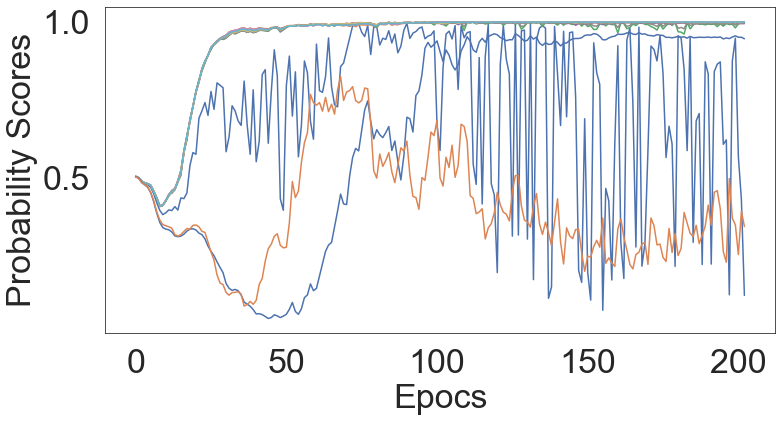

In [145]:
fig, ax1 = plt.subplots()
sns.set_palette("deep")
sns.set_style("white")
line_styles = ['solid', 'dashed', 'dashdot', 'dotted']
# plt.figure(figsize=(10, 4))
# df = pd.DataFrame({'values':values, 'tag':tag})
xticks_list=[]
categories =[x for x in range(21)]
for x in range(21):
    xticks_list.append(str(x))
xticks_list.append('20+')
markers = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D',
           '|', '_', 'd', '8', ',', '.', 'o', 'v', '^', '<', '>']

x = [i for i in range(22)]

for i in range(len(main_lst[0])):
    lst = [tensor[i].item() for tensor in main_lst]
    sns.lineplot(x=range(len(lst)), y=lst)
# for i in range(len(new_lst)):
#     lst = new_lst[i]
#     sns.lineplot(x,lst, marker=markers[i], label=app_list[i],ms=18, lw=5, ax=ax1)

# ax1.set_xticks(x)
# ax1.set_xticklabels(xticks_list, rotation=90)
fs=34
font_size = 34

# # plt.title('Histogram of Candidate Ranking')
ax1.set_xlabel('Epocs', fontsize=fs)
ax1.set_ylabel('Probability Scores', fontsize=fs)
ax1.tick_params(axis='both', which='major', pad=12)
ax1.tick_params(axis='y', which='major', labelsize=fs)
ax1.tick_params(axis='x', which='major', labelsize=fs)
# ax1.legend(app_list, loc='lower right', ncol=2, prop={'size':font_size})
plt.rcParams["figure.figsize"] = (12, 6)
plt.savefig("candidate_figures/probability_score_per_epoc.pdf", bbox_inches='tight', pad_inches=0, transparent=True)

In [ ]:
# MODEL_NAME = 'GatedGCN'

# to_do_list = ['Inquirer.js', 'underscore', 'angular', 'shelljs', 'js-yaml', 'commander.js', 'bluebird', 'through2', 'classnames', 
# 'body-parser', 'uuid', 'async', 'tslib', 'rxjs', 'core', 'package','q', 'node-fs-extra', 'request', 'minimist', 
# 'prop-types','debug', 'axios', 'colors.js','react']
# app_list =  ['Inquirer.js', 'underscore', 'angular', 'shelljs', 'js-yaml', 'commander.js', 'bluebird', 'through2', 'classnames', 
# 'body-parser', 'uuid', 'async', 'tslib', 'rxjs', 'core', 'package','q', 'node-fs-extra', 'request', 'minimist', 
# 'prop-types','debug', 'axios', 'colors.js','react']


# for i in range(len(to_do_list)):
#     main_lst = []
#     APPLICATION_NAME = app_list[i]
#     DATASET_NAME = 'NEW_DATASET--'+APPLICATION_NAME
#     PATH = "results/NEW_DATASET--"+APPLICATION_NAME+"/"+MODEL_NAME
#     EPOCS = get_EPOC_Number(PATH=PATH)
#     print(EPOCS)
#     dataset = load_datset(DATASET_NAME)
#     net_params, params = set_parameters(MODEL_NAME, dataset, DATASET_NAME)
#     EPOC_NUMBER = EPOCS
#     model, graph = train_model(dataset, EPOC_NUMBER, APPLICATION_NAME, net_params, params, MODEL_NAME)
#     test_df = get_function_edge(APPLICATION_NAME)
#     node_df_org = pd.read_csv("../prune_new/"+APPLICATION_NAME+"_node.csv")
#     test_edges = torch.from_numpy(test_df.to_numpy())

#     test_edges, test_pred = evaluate_network(
#                         model, device, graph, test_edges, params['batch_size'], DATASET_NAME=DATASET_NAME, MODEL_NAME=MODEL_NAME, SOURCE_NODE=0, APPLICATION_NAME=APPLICATION_NAME, TARGET=0)
#     cutoff_thrshld = 0.8
#     # main_lst.append(test_pred)
#     # plot_figure(main_lst, APPLICATION_NAME, MODEL_NAME)
#     # get_optimal_index(main_lst)

#     import seaborn as sns
#     import matplotlib.pyplot as plt

#     print(test_pred)

#     # Create a histogram plot using Seaborn
#     sns.histplot(test_pred, bins=10, kde=True, color='skyblue')

#     # Customize the plot (optional)
#     plt.title('Histogram Plot')
#     plt.xlabel('Values')
#     plt.ylabel('Frequency')

#     # Show the plot
#     # plt.show()
#     plt.savefig("figures/"+APPLICATION_NAME+"_histogram_"+MODEL_NAME+".pdf")
#     plt.close()


In [ ]:
def get_file_name(src):
    node_df_org = pd.read_csv("../prune_new/"+APPLICATION_NAME+"_node.csv")
    node_df = node_df_org[node_df_org['new_id']==src].reset_index(drop=True)
    file_name = node_df.iloc[0]['file_name']

    return file_name
   

In [ ]:
# to_do_list = ['Inquirer.js', 'underscore', 'angular', 'shelljs', 'js-yaml', 'commander.js', 'bluebird', 'through2', 'classnames', 
# 'body-parser', 'uuid', 'async', 'tslib', 'rxjs', 'core', 'package','q', 'node-fs-extra', 'request', 'minimist', 
# 'prop-types','debug', 'axios', 'colors.js','react']
# app_list =  ['Inquirer.js', 'underscore', 'angular', 'shelljs', 'js-yaml', 'commander.js', 'bluebird', 'through2', 'classnames', 
# 'body-parser', 'uuid', 'async', 'tslib', 'rxjs', 'core', 'package','q', 'node-fs-extra', 'request', 'minimist', 
# 'prop-types','debug', 'axios', 'colors.js','react']

to_do_list = ['formula-parser', 'lodash', 'js-yaml','express']
app_list =  ['formula-parser', 'lodash', 'js-yaml','express']


for APPLICATION_NAME in to_do_list:
    try:
        print(APPLICATION_NAME)
        df = pd.read_csv("leftout_"+APPLICATION_NAME+".csv")
        # print(df)
        dst_dict = dict(df.values)

        main_lst = []
        lst = []
        with open(APPLICATION_NAME+"_missing_edge_log_GatedGCN.txt", "r+") as in_file:
            for line in in_file:
                if len(line.strip())==0:
                    temp_lst =[]
                    for x in lst:
                        temp_lst.append(x)
                    if len(temp_lst)>0:
                        main_lst.append(temp_lst)
                    lst =[]
                else:
                    lst.append(line)
        count = 0
        print(len(main_lst))
        rank_lst =[]
        for lst in main_lst:
            node_lst = []
            pred_lst = []
            for line in lst:
                if "Total edge above" not in line and "RANK 1 number of edge" not in line:
                    if 'Source =====>' in line:
                        parts = line.split(" ")
                        src = int(parts[-1].strip())
                    else:
                        parts = line.split(" ")
                        # print(parts)
                        dst = int(parts[-3].strip())
                        value = float(parts[-1].strip())
                        # print(dst, value)
                        node_lst.append(dst)
                        pred_lst.append(value)
            
            result_df = pd.DataFrame(list(zip(node_lst, pred_lst)), columns =['id', 'val'])
            result_df = result_df.sort_values(by=['val'], ascending=False).reset_index(drop=True)
            
            if len(result_df)>0:
                TARGET = dst_dict[src]
                # first_index = result_df.iloc[0]['id']
                # # print(TARGET, first_index)
                # if first_index == TARGET:
                #     count+=1
                found = False
                for i in range(len(result_df)):
                    id = result_df.iloc[i]['id']
                    if id == TARGET:
                        rank_lst.append(i)
                        found = True
                # if not found:
                #     print("NOT FOUND ====> ")
                #     file_name = get_file_name(src)
                #     dst_file = get_file_name(TARGET)
                #     print(src, TARGET, file_name, dst_file)
                #     print(result_df)

        count_dict={}
        for i in range(0, 22):
            count_dict[i] = 0
        xticks_list=[]
        for x in rank_lst:
            if x >20:
                if 21 in count_dict:
                    count= count_dict[21]
                    count_dict[21]=count+1
                else:
                    count_dict[21]=1
            else:
                if x in count_dict:
                    count= count_dict[x]
                    count_dict[x]=count+1
                else:
                    count_dict[x]=1
                    
        for x in range(21):
            xticks_list.append(str(x))
        xticks_list.append('20+')
        
        count_dict = dict(sorted(count_dict.items()))
        print(count_dict)
        print(xticks_list)
        print(APPLICATION_NAME, "======> ", count, count/len(main_lst)*100)
        # len(rank_lst)
        # print(rank_list)
        import matplotlib.pyplot as plt
        import seaborn as sns

        try:
            plt.figure(figsize=(16, 8))
            categories = list(count_dict.keys())
            counts = list(count_dict.values())

            # Create a bar plot using Seaborn
            ax = sns.barplot(x=categories, y=counts)
            plt.xticks(range(len(xticks_list)), xticks_list)
            plt.title('Histogram of Candidate Ranking')
            plt.xlabel('Ranking')
            plt.ylabel('Count')
            plt.savefig("candidate_figures/positive_"+APPLICATION_NAME+".pdf")
            plt.close()
        except:
            pass
    except:
        raise

In [ ]:
import json
APPLICATION_NAME = 'express'
f = open('../connected_files/'+APPLICATION_NAME+'_dependency_graph.json')
data = json.load(f)


df = pd.read_csv("leftout_"+APPLICATION_NAME+".csv")
# print(df)
dst_dict = dict(df.values)
for src in dst_dict:
    TARGET = dst_dict[src]
    file_name = get_file_name(src)
    dst_file = get_file_name(TARGET)
    # print(src, TARGET, file_name, dst_file)
    if file_name!=dst_file:
        if file_name not in data:
            print(file_name, src, dst_file)
            # print(file_name==dst_file)
            # pass
        else:
            lst = data[file_name]
            if dst_file not in lst:
                print(src, TARGET, file_name, dst_file)

In [ ]:
APPLICATION_NAME = "formula-parser"
print(APPLICATION_NAME)
# df = pd.read_csv("leftout_"+APPLICATION_NAME+".csv")
# # print(df)
# dst_dict = dict(df.values)

main_lst = []
lst = []
should_start = False
what_we_looking_for = "/Users/masudulhasanmasudbhuiyan/Documents/gitlab/libraries/formula-parser/dist/formula-parser.js apply 158 15 371"
with open(APPLICATION_NAME+"_missing_edge_log_GatedGCN_with_epoc_174_new.txt", "r+") as in_file:
    for line in in_file:
        if what_we_looking_for in line:
            lst.append(line)
            should_start = True
        else:
            if should_start:
                if len(line.strip())==0:
                    temp_lst =[]
                    for x in lst:
                        temp_lst.append(x)
                    if len(temp_lst)>0:
                        main_lst.append(temp_lst)
                    lst =[]
                    should_start = False
                else:
                    lst.append(line)

count = 0
print(len(main_lst))
rank_lst =[]
for lst in main_lst:
    node_lst = []
    pred_lst = []
    for line in lst:
        if "Total " not in line and "RANK 1 number of edge" not in line:
            if 'Source =====>' in line:
                parts = line.split(" ")
                src = int(parts[-1].strip())
            else:
                parts = line.split(" ")
                # print(parts)
                dst = int(parts[-3].strip())
                value = float(parts[-1].strip())
                # print(dst, value)
                node_lst.append(dst)
                pred_lst.append(value)
    
    result_df = pd.DataFrame(list(zip(node_lst, pred_lst)), columns =['id', 'val'])
    result_df = result_df.sort_values(by=['val'], ascending=False).reset_index(drop=True)
    print(len(result_df))
    if len(result_df)>0:
        TARGET = 380
        # first_index = result_df.iloc[0]['id']
        # # print(TARGET, first_index)
        # if first_index == TARGET:
        #     count+=1
        found = False
        for i in range(len(result_df)):
            id = result_df.iloc[i]['id']
            if id == TARGET:
                print("RANK ====> ", i)
        # if not found:
        #     print("NOT FOUND ====> ")
        #     file_name = get_file_name(src)
        #     dst_file = get_file_name(TARGET)
        #     print(src, TARGET, file_name, dst_file)
        #     print(result_df)

# print(APPLICATION_NAME, "======> ", count, count/len(main_lst)*100)
# import matplotlib.pyplot as plt
# import seaborn as sns
# try:
#     plt.figure(figsize=(16, 8))
#     sns.distplot(rank_lst, hist=True, kde=False, 
#                 bins=int(max(rank_lst)/2), color = 'blue',
#                 hist_kws={'edgecolor':'black'})
#     # Add labels

#     plt.title('Histogram of Candidate Ranking')
#     plt.xlabel('Ranking')
#     plt.ylabel('Count')
#     plt.savefig("candidate_figures/positive_"+APPLICATION_NAME+".pdf")
#     plt.close()
# except:
#     pass


In [ ]:
def generate_test_data(APPLICATION_NAME):
    # print(src_id)
    ROOT_PATH = "../prune_new/"
    df = pd.read_csv(ROOT_PATH+ APPLICATION_NAME+'_node.csv')
    d = dict()
    f = open('../connected_files/'+APPLICATION_NAME+'_dependency_graph.json')
    data = json.load(f)

    for key in data:
        # print(key, data[key])
        new_lst = []
        new_lst.append(key)
        try:
            lst = data[key]
            for x in lst:
                if "lodash/internal" in x:
                    x = x.replace("lodash/internal","lodash/.internal")
                new_lst.append(x)
        except:
            pass
        # print(new_lst)
    
        stmt_type=['FunctionDeclaration', 'ArrowFunctionExpression', 'FunctionExpression']
        dst_df = df[(df.type.isin(stmt_type)) & (df.file_name.isin(new_lst))]
        test_neg_id = dst_df['new_id'].tolist()
        d[key]=test_neg_id
    outfile = open("candidate_edge_files/"+APPLICATION_NAME+"_candidate_edges.json","w+")
    json.dump(d, outfile, indent=4)

In [ ]:
import pandas as pd
import json
import torch
# lst = ['formula-parser', 'lodash', 'js-yaml','express']
lst = ['mathjs', 'winston', 'ws', 'qs', 'node-fs-extra', 'UglifyJS']
for APPLICATION_NAME in lst:
    generate_test_data(APPLICATION_NAME)

express
124
[0.9457654953, 0.618196249008, 0.921575546265, 3.43001e-07, 0.947471678257, 0.928295373917, 0.993883371353, 0.743050634861, 0.349585801363, 0.995141386986, 0.873815000057, 0.971981346607, 0.886882722378, 0.915125131607, 0.882611691952, 0.866290390491, 0.821971833706, 0.910236120224, 0.798352599144, 0.99357187748, 0.99941432476, 0.999684095383, 0.999817788601, 0.999757707119, 0.999596655369, 0.999721944332, 0.998843312263, 0.999053061008, 0.999168395996, 0.529251456261, 0.999883651733, 0.999840259552, 0.996940732002, 0.995318710804, 0.950152218342, 0.013511179015, 0.995322883129, 0.995507836342, 0.995304107666, 0.999390125275, 0.99842852354, 0.999155163765, 0.999155163765, 0.993784546852, 0.999858021736, 0.999781787395, 0.761736273766, 0.491238355637, 0.881474554539, 0.432850241661, 0.432562112808, 0.970128834248, 0.985489189625, 0.947934269905, 0.616860091686, 0.82504016161, 0.582608044147, 0.999530911446, 0.998854756355, 0.890807688236, 0.950513124466, 0.181404396892, 0.92

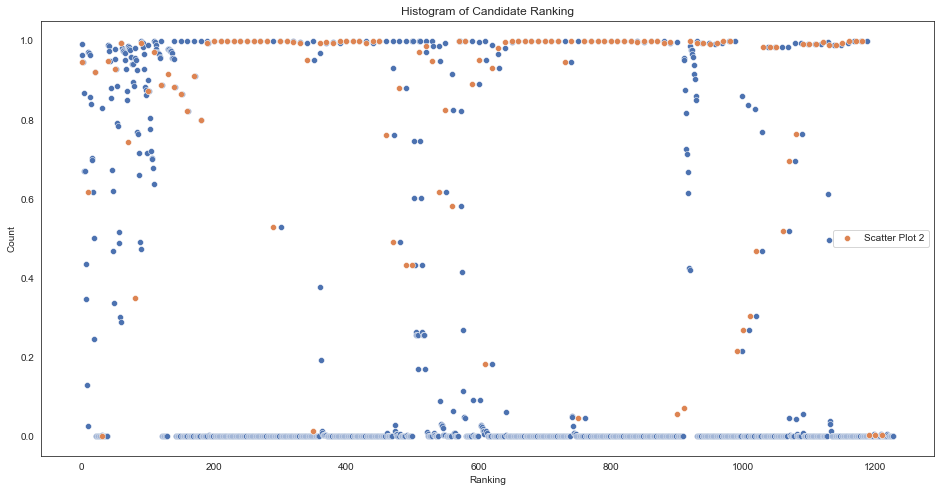

In [147]:
# to_do_list = ['formula-parser', 'lodash', 'js-yaml','express']
# app_list =  ['formula-parser', 'lodash', 'js-yaml','express']

to_do_list = ['express']
app_list =  ['express']


for APPLICATION_NAME in to_do_list:
    try:
        print(APPLICATION_NAME)
        df = pd.read_csv("../prune+bidirectional+semantic_edge+dynamic_edge/leftout_"+APPLICATION_NAME+".csv")
        # print(df)
        dst_dict = dict(df.values)

        main_lst = []
        lst = []
        with open("missing_edges_log/"+APPLICATION_NAME+"_missing_edge_log_GatedGCN.txt", "r+") as in_file:
            for line in in_file:
                if len(line.strip())==0:
                    temp_lst =[]
                    for x in lst:
                        temp_lst.append(x)
                    if len(temp_lst)>0:
                        main_lst.append(temp_lst)
                    lst =[]
                else:
                    lst.append(line)
        count = 0
        print(len(main_lst))
        rank_lst =[]
        all_value_list= []
        for lst in main_lst:
            node_lst = []
            pred_lst = []
            for line in lst:
                if "Total edge above" not in line and "RANK 1 number of edge" not in line:
                    if 'Source =====>' in line:
                        parts = line.split(" ")
                        src = int(parts[-1].strip())
                    else:
                        parts = line.split(" ")
                        # print(parts)
                        dst = int(parts[-3].strip())
                        value = float(parts[-1].strip())
                        # print(dst, value)
                        node_lst.append(dst)
                        pred_lst.append(value)
            
            result_df = pd.DataFrame(list(zip(node_lst, pred_lst)), columns =['id', 'val'])
            result_df = result_df.sort_values(by=['val'], ascending=False).reset_index(drop=True)
            try:
                if len(result_df)>0:
                    TARGET = dst_dict[src]
                    for i in range(len(result_df)):
                        id = result_df.iloc[i]['id']
                        if id == TARGET:
                            val = result_df.iloc[i]['val']
                            rank_lst.append(val)
                            found = True
            except:
                pass

            result_df = result_df[:10]
            all_value_list+=result_df['val'].tolist()

        print(rank_lst)
        print(len(rank_lst))

            
        # import matplotlib.pyplot as plt
        # import seaborn as sns

        # try:
        plt.figure(figsize=(16, 8))
        x = np.arange(0, len(all_value_list),1)
        # Create a bar plot using Seaborn
        ax = sns.scatterplot(x=x, y=all_value_list)
        x2 = np.arange(0,len(rank_lst)*10,10)
        # print(len(x2))
        sns.scatterplot(x=x2, y=rank_lst, label='Scatter Plot 2')
        # plt.xticks(range(len(xticks_list)), xticks_list)
        plt.title('Histogram of Candidate Ranking')
        plt.xlabel('Ranking')
        plt.ylabel('Count')
        # plt.savefig("candidate_figures/scatterplot_"+APPLICATION_NAME+".pdf")
        # plt.close()
        # except:
        #     pass
    except:
        raise

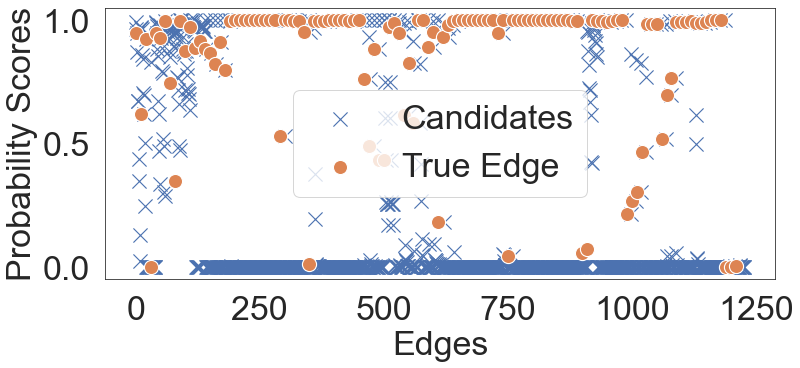

In [158]:
fig, ax1 = plt.subplots()
sns.set_palette("deep")
sns.set_style("white")
line_styles = ['solid', 'dashed', 'dashdot', 'dotted']
# plt.figure(figsize=(10, 4))
# df = pd.DataFrame({'values':values, 'tag':tag})
xticks_list=[]
categories =[x for x in range(21)]
for x in range(21):
    xticks_list.append(str(x))
xticks_list.append('20+')
markers = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D',
           '|', '_', 'd', '8', ',', '.', 'o', 'v', '^', '<', '>']

x = np.arange(0, len(all_value_list),1)
# Create a bar plot using Seaborn
ax = sns.scatterplot(x=x, y=all_value_list,marker="x",s=200, label='Candidates')
x2 = np.arange(0,len(rank_lst)*10,10)
sns.scatterplot(x=x2, y=rank_lst, marker="o", s=200,label='True Edge')

# ax1.set_xticks(x)
# ax1.set_xticklabels(xticks_list, rotation=90)
fs=34
font_size = 34

# # plt.title('Histogram of Candidate Ranking')
ax1.set_xlabel('Edges', fontsize=fs)
ax1.set_ylabel('Probability Scores', fontsize=fs)
ax1.tick_params(axis='both', which='major', pad=12)
ax1.tick_params(axis='y', which='major', labelsize=fs)
ax1.tick_params(axis='x', which='major', labelsize=fs)
ax1.legend(loc='best', ncol=1, prop={'size':font_size})
plt.rcParams["figure.figsize"] = (12, 5)
plt.savefig("candidate_figures/probability_score_per_edge.pdf", bbox_inches='tight', pad_inches=0, transparent=True)

express
2646
[0.993723452091, 0.962548673153, 0.988426446915, 0.991690278053, 0.988426566124, 0.988426566124, 0.988426566124, 0.978401184082, 0.187430247664, 0.990900039673, 0.000317864382, 0.41600266099, 0.416002511978, 0.001443830784, 0.000159964693, 0.588755965233, 0.90254598856, 0.986507534981, 0.647388219833, 0.156397268176, 0.941767632961, 0.975458800793, 0.43371707201, 0.997057557106, 0.087094135582, 0.277442127466, 3.9266e-08, 0.004127359483, 0.285939455032, 1.819136e-06, 0.943987488747, 0.894383013248, 0.169520437717, 0.239444732666, 0.999027371407, 0.231717064977, 0.998537898064, 0.24664658308, 0.929002761841, 0.000112415328, 7.438748e-06, 7.438739e-06, 0.984400808811, 0.035285457969, 7.91651e-07, 4.87033e-07, 0.993464291096, 8.36432e-07, 0.991966485977, 0.997385203838, 0.99638402462, 0.99275803566, 0.977178573608, 0.994374632835, 1.028073e-06, 1.9293328e-05, 0.998104929924, 0.995053470135, 0.995532989502, 3.808935e-06, 1.438448e-06, 5.454072e-06, 0.00242404826, 5.213395e-06,

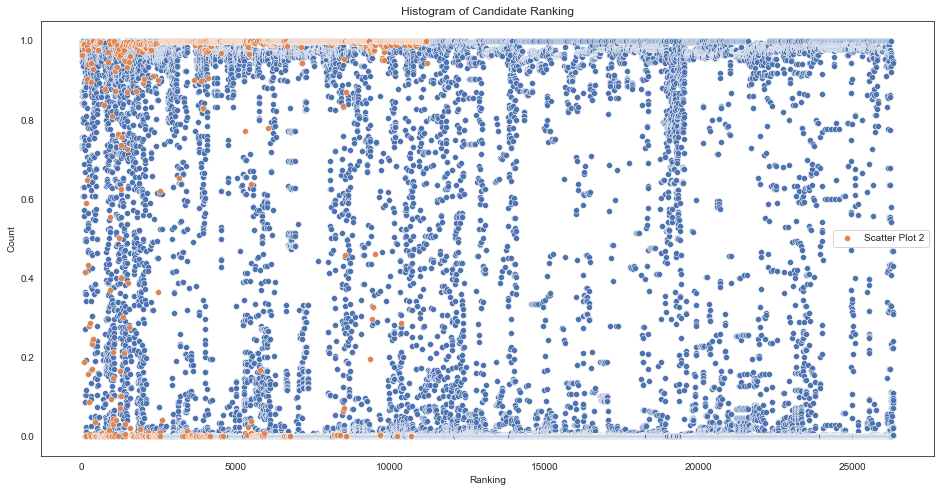

In [173]:
# to_do_list = ['formula-parser', 'lodash', 'js-yaml','express']
# app_list =  ['formula-parser', 'lodash', 'js-yaml','express']

to_do_list = ['express']
app_list =  ['express']


for APPLICATION_NAME in to_do_list:
    try:
        print(APPLICATION_NAME)
        df = pd.read_csv('../prune+bidirectional+semantic_edge+dynamic_edge/dynamic_edges/prune_dynamic_edges_'+APPLICATION_NAME+'.csv')
        df = df.drop_duplicates().reset_index(drop=True)
        dst_dict = dict(df.values)

        main_lst = []
        lst = []
        with open("dynamic_"+APPLICATION_NAME+"_missing_edge_log_GatedGCN.txt", "r+") as in_file:
            for line in in_file:
                if len(line.strip())==0:
                    temp_lst =[]
                    for x in lst:
                        temp_lst.append(x)
                    if len(temp_lst)>0:
                        main_lst.append(temp_lst)
                    lst =[]
                else:
                    lst.append(line)
        count = 0
        print(len(main_lst))
        rank_lst =[]
        all_value_list= []
        for lst in main_lst:
            node_lst = []
            pred_lst = []
            for line in lst:
                if "Total edge above" not in line and "RANK 1 number of edge" not in line:
                    if 'Source =====>' in line:
                        parts = line.split(" ")
                        src = int(parts[-1].strip())
                    else:
                        parts = line.split(" ")
                        # print(parts)
                        dst = int(parts[-3].strip())
                        value = float(parts[-1].strip())
                        # print(dst, value)
                        node_lst.append(dst)
                        pred_lst.append(value)
            
            result_df = pd.DataFrame(list(zip(node_lst, pred_lst)), columns =['id', 'val'])
            result_df = result_df.sort_values(by=['val'], ascending=False).reset_index(drop=True)
            try:
                if len(result_df)>0:
                    TARGET = dst_dict[src]
                    for i in range(len(result_df)):
                        id = result_df.iloc[i]['id']
                        if id == TARGET:
                            val = result_df.iloc[i]['val']
                            rank_lst.append(val)
                            found = True
            except:
                pass

            result_df = result_df[:10]
            all_value_list+=result_df['val'].tolist()

        print(rank_lst)
        print(len(rank_lst))

            
        # import matplotlib.pyplot as plt
        # import seaborn as sns

        # try:
        plt.figure(figsize=(16, 8))
        x = np.arange(0, len(all_value_list),1)
        # Create a bar plot using Seaborn
        ax = sns.scatterplot(x=x, y=all_value_list)
        x2 = np.arange(0,len(rank_lst)*10,10)
        # print(len(x2))
        sns.scatterplot(x=x2, y=rank_lst, label='Scatter Plot 2')
        # plt.xticks(range(len(xticks_list)), xticks_list)
        plt.title('Histogram of Candidate Ranking')
        plt.xlabel('Ranking')
        plt.ylabel('Count')
        # plt.savefig("candidate_figures/scatterplot_"+APPLICATION_NAME+".pdf")
        # plt.close()
        # except:
        #     pass
    except:
        raise

In [ ]:
fig, ax1 = plt.subplots()
sns.set_palette("deep")
sns.set_style("white")
line_styles = ['solid', 'dashed', 'dashdot', 'dotted']
# plt.figure(figsize=(10, 4))
# df = pd.DataFrame({'values':values, 'tag':tag})
xticks_list=[]
categories =[x for x in range(21)]
for x in range(21):
    xticks_list.append(str(x))
xticks_list.append('20+')
markers = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D',
           '|', '_', 'd', '8', ',', '.', 'o', 'v', '^', '<', '>']

x = np.arange(0, len(all_value_list),1)
# Create a bar plot using Seaborn
ax = sns.scatterplot(x=x, y=all_value_list,marker="x",s=200, label='Candidates')
x2 = np.arange(0,len(rank_lst)*10,10)
sns.scatterplot(x=x2, y=rank_lst, marker="o", s=200,label='True Edge')

# ax1.set_xticks(x)
# ax1.set_xticklabels(xticks_list, rotation=90)
fs=34
font_size = 34

# # plt.title('Histogram of Candidate Ranking')
ax1.set_xlabel('Edges', fontsize=fs)
ax1.set_ylabel('Probability Scores', fontsize=fs)
ax1.tick_params(axis='both', which='major', pad=12)
ax1.tick_params(axis='y', which='major', labelsize=fs)
ax1.tick_params(axis='x', which='major', labelsize=fs)
ax1.legend(loc='best', ncol=1, prop={'size':font_size})
plt.rcParams["figure.figsize"] = (12, 5)
# plt.savefig("candidate_figures/probability_score_per_edge.pdf", bbox_inches='tight', pad_inches=0, transparent=True)

In [ ]:
to_do_list = ['formula-parser', 'lodash', 'js-yaml','express']
app_list =  ['formula-parser', 'lodash', 'js-yaml','express']

MODEL_NAME = 'GatedGCN'
for APPLICATION_NAME in to_do_list:
    try:
        print(APPLICATION_NAME)
        main_lst = []
        lst = []
        PATH = "results/NEW_DATASET--"+APPLICATION_NAME+"/"+MODEL_NAME
        EPOC_NUMBER = get_EPOC_Number(PATH=PATH)
        print(PATH)
        with open(APPLICATION_NAME+"_missing_edge_log_GatedGCN_with_epoc_"+str(EPOC_NUMBER)+"_new.txt", "r+") as in_file:
            for line in in_file:
                if len(line.strip())==0:
                    temp_lst =[]
                    for x in lst:
                        temp_lst.append(x)
                    if len(temp_lst)>0:
                        main_lst.append(temp_lst)
                    lst =[]
                else:
                    lst.append(line)
        count = 0
        print(len(main_lst))
        rank_lst =[]
        all_value_list= []
        for lst in main_lst:
            node_lst = []
            pred_lst = []
            for line in lst:
                if "Total" not in line and "RANK 1 number of edge" not in line:
                    if 'Source =====>' in line:
                        parts = line.split(" ")
                        src = int(parts[-1].strip())
                    else:
                        parts = line.split(" ")
                        # print(parts)
                        dst = int(parts[-3].strip())
                        value = float(parts[-1].strip())
                        # print(dst, value)
                        node_lst.append(dst)
                        pred_lst.append(value)
            
            result_df = pd.DataFrame(list(zip(node_lst, pred_lst)), columns =['id', 'val'])
            result_df = result_df.sort_values(by=['val'], ascending=False).reset_index(drop=True)
            result_df = result_df[:10]
            all_value_list+=result_df['val'].tolist()

        # print(rank_lst)
        # print(len(all_value_list))

            
        import matplotlib.pyplot as plt
        import seaborn as sns

        # try:
        plt.figure(figsize=(16, 8))
        x = np.arange(0, len(all_value_list),1)
        # Create a bar plot using Seaborn
        ax = sns.scatterplot(x=x, y=all_value_list)
        # sns.histplot(all_value_list, kde=True, bins=10)
        # sns.kdeplot(all_value_list, shade=True)
        # plt.xticks(range(len(xticks_list)), xticks_list)
        plt.title('Histogram of Candidate Ranking')
        plt.xlabel('Ranking')
        plt.ylabel('Count')
        plt.savefig("candidate_figures/missing_scatterplot_"+APPLICATION_NAME+".pdf")
        plt.close()
        # plt.show()
        # except:
        #     pass
    except:
        raise

In [ ]:
to_do_list = ['formula-parser']
app_list =  ['formula-parser']


for APPLICATION_NAME in to_do_list:
    try:
        print(APPLICATION_NAME)
        df = pd.read_csv("../prune+bidirectional+semantic_edge+dynamic_edge/leftout_"+APPLICATION_NAME+".csv")
        # print(df)
        dst_dict = dict(df.values)

        main_lst = []
        lst = []
        with open("missing_edges_log/"+APPLICATION_NAME+"_missing_edge_log_GatedGCN.txt", "r+") as in_file:
            for line in in_file:
                if len(line.strip())==0:
                    temp_lst =[]
                    for x in lst:
                        temp_lst.append(x)
                    if len(temp_lst)>0:
                        main_lst.append(temp_lst)
                    lst =[]
                else:
                    lst.append(line)
        count = 0
        print(len(main_lst))
        rank_lst =[]
        all_value_list= []
        for lst in main_lst:
            node_lst = []
            pred_lst = []
            for line in lst:
                if "Total edge above" not in line and "RANK 1 number of edge" not in line:
                    if 'Source =====>' in line:
                        parts = line.split(" ")
                        src = int(parts[-1].strip())
                        src_line = line
                    else:
                        parts = line.split(" ")
                        # print(parts)
                        dst = int(parts[-3].strip())
                        value = float(parts[-1].strip())
                        # print(dst, value)
                        node_lst.append(dst)
                        pred_lst.append(value)
            
            result_df = pd.DataFrame(list(zip(node_lst, pred_lst)), columns =['id', 'val'])
            result_df = result_df.sort_values(by=['val'], ascending=False).reset_index(drop=True)
            try:
                if len(result_df)>0:
                    TARGET = dst_dict[src]
                    for i in range(len(result_df)):
                        id = result_df.iloc[i]['id']
                        if id == TARGET:
                            val = result_df.iloc[i]['val']
                            rank_lst.append(val)
                            found = True
            except:
                pass

            result_df = result_df[:10]
            print("SRC =====> ", src_line, val)
            print(result_df)
            all_value_list+=result_df['val'].tolist()

        print(rank_lst)
        print(len(rank_lst))

        
    except:
        raise

In [166]:
to_do_list = ['formula-parser', 'lodash', 'js-yaml','express', 'mathjs', 'winston', 'ws', 'qs', 'node-fs-extra', 'UglifyJS']
app_list =  ['formula-parser', 'lodash', 'js-yaml','express', 'mathjs', 'winston', 'ws', 'qs', 'node-fs-extra', 'UglifyJS']

MODEL_NAME = 'GatedGCN'
new_lst = []
for APPLICATION_NAME in to_do_list:
    try:
        print(APPLICATION_NAME)
        df = pd.read_csv('../prune+bidirectional+semantic_edge+dynamic_edge/dynamic_edges/prune_dynamic_edges_'+APPLICATION_NAME+'.csv')
        df = df.drop_duplicates().reset_index(drop=True)
        ids = df['src'].tolist()
        lst = ids
        dst_dict = dict(df.values)

        main_lst = []
        lst = []
        with open("dynamic_"+APPLICATION_NAME+"_missing_edge_log_"+MODEL_NAME+".txt", "r+") as in_file:
            for line in in_file:
                if len(line.strip())==0:
                    temp_lst =[]
                    for x in lst:
                        temp_lst.append(x)
                    if len(temp_lst)>0:
                        main_lst.append(temp_lst)
                    lst =[]
                else:
                    lst.append(line)
        count = 0
        print(len(main_lst))
        rank_lst =[]
        for lst in main_lst:
            node_lst = []
            pred_lst = []
            for line in lst:
                if "Total edge above" not in line and "RANK 1 number of edge" not in line:
                    if 'Source =====>' in line:
                        parts = line.split(" ")
                        src = int(parts[-1].strip())
                    else:
                        parts = line.split(" ")
                        # print(parts)
                        dst = int(parts[-3].strip())
                        value = float(parts[-1].strip())
                        # print(dst, value)
                        node_lst.append(dst)
                        pred_lst.append(value)
            
            result_df = pd.DataFrame(list(zip(node_lst, pred_lst)), columns =['id', 'val'])
            result_df = result_df.sort_values(by=['val'], ascending=False).reset_index(drop=True)
            
            if len(result_df)>0:
                TARGET = dst_dict[src]
                found = False
                for i in range(len(result_df)):
                    id = result_df.iloc[i]['id']
                    if id == TARGET:
                        rank_lst.append(i)
                        found = True

        count_dict={}
        for i in range(0, 22):
            count_dict[i] = 0
        xticks_list=[]
        for x in rank_lst:
            if x >20:
                if 21 in count_dict:
                    count= count_dict[21]
                    count_dict[21]=count+1
                else:
                    count_dict[21]=1
            else:
                if x in count_dict:
                    count= count_dict[x]
                    count_dict[x]=count+1
                else:
                    count_dict[x]=1
                    
        # for x in range(21):
        #     xticks_list.append(str(x))
        # xticks_list.append('20+')
        
        count_dict = dict(sorted(count_dict.items()))
        # print(count_dict)
        # print(xticks_list)
        # print(APPLICATION_NAME, "======> ", count, count/len(main_lst)*100)
        # # len(rank_lst)
        # # print(rank_list)
        # import matplotlib.pyplot as plt
        # import seaborn as sns

        # try:
        #     plt.figure(figsize=(16, 8))
        categories = list(count_dict.keys())
        counts = list(count_dict.values())

        cumsum_lst = np.cumsum(counts)
        perc_lst = 100*cumsum_lst/np.sum(counts)
        perc_lst = [int(x) for x in perc_lst]
        new_lst.append(perc_lst)
        # print(perc_lst)

        #     # Create a bar plot using Seaborn
        #     ax = sns.barplot(x=categories, y=counts)
        #     plt.xticks(range(len(xticks_list)), xticks_list)
        #     plt.title('Histogram of Candidate Ranking')
        #     plt.xlabel('Ranking')
        #     plt.ylabel('Count')
        #     # plt.savefig("candidate_figures/positive_"+APPLICATION_NAME+".pdf")
        #     # plt.close()
        # except:
        #     pass
    except:
        raise

formula-parser
549
lodash
401
js-yaml
258
express
2646
mathjs
365
winston
431
ws
334
qs
142
node-fs-extra
596
UglifyJS
136


In [175]:
# for lst in new_lst:
#     print(lst)
weighted_sum = 0
app_list =  ['formula-parser', 'lodash', 'js-yaml','express', 'mathjs', 'winston', 'ws', 'qs', 'node-fs-extra', 'UglifyJS']
weight = 0
for i in range(len(app_list)):
    APPLICATION_NAME = app_list[i]
    func_df = pd.read_csv("../prune+bidirectional+semantic_edge+dynamic_edge/dynamic_edges/prune_dynamic_edges_"+APPLICATION_NAME+".csv")
    func_df = func_df.drop_duplicates(keep='first').reset_index(drop=True)
    weighted_sum += len(func_df)*new_lst[i][0]
    weight += len(func_df)

print(weighted_sum/weight)

49.38409239842726


In [ ]:
fig, ax1 = plt.subplots()
sns.set_palette("deep")
sns.set_style("white")
line_styles = ['solid', 'dashed', 'dashdot', 'dotted']
# plt.figure(figsize=(10, 4))
# df = pd.DataFrame({'values':values, 'tag':tag})
xticks_list=[]
categories =[x for x in range(21)]
for x in range(21):
    xticks_list.append(str(x))
xticks_list.append('20+')
markers = ['.', ',', 'o', 'v', '^', '<', '>', '*', 'h', 'H', '+', 'x', 'D',
           '|', '_', 'd', '8', ',', '.', 'o', 'v', '^', '<', '>']

x = [i for i in range(22)]
for i in range(len(new_lst)):
    lst = new_lst[i]
    sns.lineplot(x,lst, marker=markers[i], label=app_list[i],ms=18, lw=5, ax=ax1)
# for lines, marker, legend_handle in zip(ax1.lines[::-1], markers, ax1.legend_.legendHandles):
#     lines.set_marker(marker)
#     # legend_handle.set_marker(marker)
# plt.xticks(range(len(xticks_list)), xticks_list)
ax1.set_xticks(x)
ax1.set_xticklabels(xticks_list, rotation=90)
# ax1.set(ylabel='I/O save(%)', xlabel='Improvement Factor')
# # plt.legend(ncol=3)

fs=34
font_size = 24

# # plt.title('Histogram of Candidate Ranking')
ax1.set_xlabel('Ranking', fontsize=fs)
ax1.set_ylabel('Cumulative Probability (%)', fontsize=fs)
# plt.xlabel('Ranking')
# plt.ylabel('Proportion')
# plt.subplots_adjust(top = 0.99, bottom = 0.2, right = 0.95, left = 0.05, 
#             hspace = 0, wspace = 0)

# plt.ylabel("Proportion", fontsize=fs, labelpad=10)
# plt.xlabel("Ranking", fontsize=fs, labelpad=0)
# # plt.ylim(-1,1)
# # plt.xlim(0,4)
# # plt.setp(ax.get_legend().get_texts(), fontsize=fs)
# # plt.legend(prop={'size':fs}, loc='best')
ax1.tick_params(axis='both', which='major', pad=12)
ax1.tick_params(axis='y', which='major', labelsize=fs)
ax1.tick_params(axis='x', which='major', labelsize=fs)
# ax1.legend(app_list, loc='lower right', ncol=4, prop={'size':font_size})
ax1.legend(app_list, loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=4, prop={'size':font_size})
# ax1.legend(app_list,ncol=2, prop={'size':font_size})
# plt.tick_params(axis='both', which='major')
# plt.tick_params(axis='y', which='major', labelsize=fs)
# plt.tick_params(axis='x', which='major', labelsize=fs, rotation=90)
plt.rcParams["figure.figsize"] = (16, 5)
# plt.tight_layout()
# plt.savefig("transfer_learning.pdf",bbox_inches='tight', pad_inches=0, transparent=True)
plt.savefig("candidate_figures/dynamic_distribution.pdf", bbox_inches='tight', pad_inches=0, transparent=True)

In [ ]:
def get_dict(FILE_PATH, dst_dict,rank_count):
    main_lst = []
    lst = []
    with open(FILE_PATH, "r+") as in_file:
        for line in in_file:
            if len(line.strip())==0:
                temp_lst =[]
                for x in lst:
                    temp_lst.append(x)
                if len(temp_lst)>0:
                    main_lst.append(temp_lst)
                lst =[]
            else:
                lst.append(line)
    count = 0
    print(len(main_lst))
    rank_lst =[]
    for lst in main_lst:
        node_lst = []
        pred_lst = []
        for line in lst:
            if "Total edge above" not in line and "RANK 1 number of edge" not in line:
                if 'Source =====>' in line:
                    parts = line.split(" ")
                    src = int(parts[-1].strip())
                else:
                    parts = line.split(" ")
                    dst = int(parts[-3].strip())
                    value = float(parts[-1].strip())
                    node_lst.append(dst)
                    pred_lst.append(value)
        
        result_df = pd.DataFrame(list(zip(node_lst, pred_lst)), columns =['id', 'val'])
        result_df = result_df.sort_values(by=['val'], ascending=False).reset_index(drop=True)
        
        if len(result_df)>0:
            TARGET = dst_dict[src]
            found = False
            for i in range(len(result_df)):
                id = result_df.iloc[i]['id']
                if id == TARGET:
                    rank_lst.append(i)
                    found = True

    count_dict={}
    for i in range(0, rank_count+2):
        count_dict[i] = 0
    for x in rank_lst:
        if x >rank_count:
            if rank_count+1 in count_dict:
                count= count_dict[rank_count+1]
                count_dict[rank_count+1]=count+1
            else:
                count_dict[rank_count+1]=1
        else:
            if x in count_dict:
                count= count_dict[x]
                count_dict[x]=count+1
            else:
                count_dict[x]=1
    count_dict = dict(sorted(count_dict.items()))
    return count_dict

to_do_list = ['formula-parser', 'lodash', 'js-yaml','express', 'mathjs']
app_list =  ['formula-parser', 'lodash', 'js-yaml','express', 'mathjs']

grahia_main_list =[]
other_main_list =[]
rank_count = 10
for APPLICATION_NAME in to_do_list:
    try:
        print(APPLICATION_NAME)
        df = pd.read_csv("../with_only_features/leftout_"+APPLICATION_NAME+".csv")
        # print(df)
        dst_dict = dict(df.values)
        count_dict = get_dict("../with_only_features/"+APPLICATION_NAME+"_missing_edge_log_GatedGCN.txt", dst_dict, rank_count)
        if APPLICATION_NAME == 'formula-parser' or APPLICATION_NAME == 'js-yaml':
            df = pd.read_csv("left_out_csv/leftout_"+APPLICATION_NAME+".csv")
            dst_dict = dict(df.values)
        if APPLICATION_NAME == 'express':
            df = pd.read_csv("../prune+bidirectional/leftout_"+APPLICATION_NAME+".csv")
            dst_dict = dict(df.values)
        without_dynamic_dict = get_dict("missing_edges_log/"+APPLICATION_NAME+"_missing_edge_log_GatedGCN.txt", dst_dict, rank_count)

        key_list =[]
        value_lst =[]
        tag_lst =[]
        counts = list(count_dict.values())
        cumsum_lst = np.cumsum(counts)
        perc_lst = 100*cumsum_lst/np.sum(counts)
        perc_lst = [int(x) for x in perc_lst]
        other_main_list.append(perc_lst)

        counts = list(without_dynamic_dict.values())
        cumsum_lst = np.cumsum(counts)
        perc_lst = 100*cumsum_lst/np.sum(counts)
        perc_lst = [int(x) for x in perc_lst]
        grahia_main_list.append(perc_lst)        
    except:
        raise

In [ ]:
import warnings
warnings.filterwarnings("ignore")
fig, ax1 = plt.subplots()
sns.set_palette("deep")
sns.set_style("white")
line_styles = ['solid', 'dashed', 'dashdot', 'dotted']
# plt.figure(figsize=(10, 4))
# df = pd.DataFrame({'values':values, 'tag':tag})
xticks_list=[]
categories =[x for x in range(rank_count+1)]
for x in range(rank_count+1):
    xticks_list.append(str(x))
xticks_list.append(str(rank_count)+'+')
markers = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D',
           '|', '_', 'd', '8', ',', '.', 'o', 'v', '^', '<', '>']

x = [i for i in range(rank_count+2)]
for i in range(len(other_main_list)):
    lst = other_main_list[i]
    sns.lineplot(x,lst, label="$Graphia_{short}$", marker=markers[0], ms= 18, color='#5a75a4', lw=5, ax=ax1)

for i in range(len(grahia_main_list)):
    lst = grahia_main_list[i]
    sns.lineplot(x,lst, label="$Graphia_{org}$", marker='*', ms=18, color='#55a968', lw=5, ax=ax1)

ax1.set_xticks(x)
ax1.set_xticklabels(xticks_list, rotation=90)
fs=34
font_size = 34

# # plt.title('Histogram of Candidate Ranking')
ax1.set_xlabel('Ranking', fontsize=fs)
ax1.set_ylabel('Cumulative Probability (%)', fontsize=fs)
ax1.tick_params(axis='both', which='major', pad=12)
ax1.tick_params(axis='y', which='major', labelsize=fs)
ax1.tick_params(axis='x', which='major', labelsize=fs)
handles, labels = plt.gca().get_legend_handles_labels()
i =1
while i<len(labels):
    if labels[i] in labels[:i]:
        del(labels[i])
        del(handles[i])
    else:
        i +=1
ax1.legend(handles, labels, loc='lower right', ncol=1, prop={'size':font_size})
plt.rcParams["figure.figsize"] = (12, 6)
plt.tight_layout()
# plt.show()
# plt.savefig("transfer_learning.pdf",bbox_inches='tight', pad_inches=0, transparent=True)
plt.savefig("candidate_figures/comparison_withonly_feature.pdf", bbox_inches='tight', pad_inches=0, transparent=True)

In [ ]:
def get_dict(FILE_PATH, dst_dict, rank_count):
    main_lst = []
    lst = []
    with open(FILE_PATH, "r+") as in_file:
        for line in in_file:
            if len(line.strip())==0:
                temp_lst =[]
                for x in lst:
                    temp_lst.append(x)
                if len(temp_lst)>0:
                    main_lst.append(temp_lst)
                lst =[]
            else:
                lst.append(line)
    count = 0
    print(len(main_lst))
    rank_lst =[]
    for lst in main_lst:
        node_lst = []
        pred_lst = []
        for line in lst:
            if "Total edge above" not in line and "RANK 1 number of edge" not in line:
                if 'Source =====>' in line:
                    parts = line.split(" ")
                    src = int(parts[-1].strip())
                else:
                    parts = line.split(" ")
                    dst = int(parts[-3].strip())
                    value = float(parts[-1].strip())
                    node_lst.append(dst)
                    pred_lst.append(value)
        
        result_df = pd.DataFrame(list(zip(node_lst, pred_lst)), columns =['id', 'val'])
        result_df = result_df.sort_values(by=['val'], ascending=False).reset_index(drop=True)
        
        if len(result_df)>0:
            TARGET = dst_dict[src]
            found = False
            for i in range(len(result_df)):
                id = result_df.iloc[i]['id']
                if id == TARGET:
                    rank_lst.append(i)
                    found = True

    count_dict={}
    for i in range(0, rank_count+2):
        count_dict[i] = 0
    for x in rank_lst:
        if x >rank_count:
            if rank_count+1 in count_dict:
                count= count_dict[rank_count+1]
                count_dict[rank_count+1]=count+1
            else:
                count_dict[rank_count+1]=1
        else:
            if x in count_dict:
                count= count_dict[x]
                count_dict[x]=count+1
            else:
                count_dict[x]=1
    count_dict = dict(sorted(count_dict.items()))
    return count_dict

to_do_list = ['formula-parser', 'lodash', 'js-yaml','express', 'mathjs']
# app_list =  ['formula-parser', 'lodash', 'js-yaml','express', 'mathjs']
# to_do_list = ['formula-parser', 'js-yaml','express']
# app_list =  ['formula-parser', 'lodash', 'js-yaml','express', 'mathjs']

grahia_main_list =[]
other_main_list =[]
rank_count = 10
for APPLICATION_NAME in to_do_list:
    try:
        print(APPLICATION_NAME)
        df = pd.read_csv("../without_features/left_out_csv/leftout_"+APPLICATION_NAME+".csv")
        # print(df)
        dst_dict = dict(df.values)
        count_dict = get_dict("../without_features/missing_edges_log/"+APPLICATION_NAME+"_missing_edge_log_GatedGCN.txt", dst_dict, rank_count)
        if APPLICATION_NAME == 'formula-parser' or APPLICATION_NAME == 'js-yaml':
            df = pd.read_csv("left_out_csv/leftout_"+APPLICATION_NAME+".csv")
            dst_dict = dict(df.values)
        if APPLICATION_NAME == 'express':
            df = pd.read_csv("../prune+bidirectional/leftout_"+APPLICATION_NAME+".csv")
            dst_dict = dict(df.values)
        without_dynamic_dict = get_dict("missing_edges_log/"+APPLICATION_NAME+"_missing_edge_log_GatedGCN.txt", dst_dict, rank_count)

        key_list =[]
        value_lst =[]
        tag_lst =[]
        counts = list(count_dict.values())
        cumsum_lst = np.cumsum(counts)
        perc_lst = 100*cumsum_lst/np.sum(counts)
        perc_lst = [int(x) for x in perc_lst]
        other_main_list.append(perc_lst)

        counts = list(without_dynamic_dict.values())
        cumsum_lst = np.cumsum(counts)
        perc_lst = 100*cumsum_lst/np.sum(counts)
        perc_lst = [int(x) for x in perc_lst]
        grahia_main_list.append(perc_lst)        
    except:
        raise

In [ ]:
import warnings
warnings.filterwarnings("ignore")
fig, ax1 = plt.subplots()
sns.set_palette("deep")
sns.set_style("white")
line_styles = ['solid', 'dashed', 'dashdot', 'dotted']
# plt.figure(figsize=(10, 4))
# df = pd.DataFrame({'values':values, 'tag':tag})
xticks_list=[]
categories =[x for x in range(rank_count+1)]
for x in range(rank_count+1):
    xticks_list.append(str(x))
xticks_list.append(str(rank_count)+'+')
markers = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D',
           '|', '_', 'd', '8', ',', '.', 'o', 'v', '^', '<', '>']

x = [i for i in range(rank_count+2)]
for i in range(len(other_main_list)):
    lst = other_main_list[i]
    sns.lineplot(x,lst, label="$Graphia_{rand}$", marker=markers[0], ms= 18, color='#c44f53', lw=5, ax=ax1)

for i in range(len(grahia_main_list)):
    lst = grahia_main_list[i]
    sns.lineplot(x,lst, label="$Graphia_{org}$", marker='*', ms=18, color='#64b5cd', lw=5, ax=ax1)

ax1.set_xticks(x)
ax1.set_xticklabels(xticks_list, rotation=90)
fs=34
font_size = 34

# # plt.title('Histogram of Candidate Ranking')
ax1.set_xlabel('Ranking', fontsize=fs)
ax1.set_ylabel('Cumulative Probability (%)', fontsize=fs)
ax1.tick_params(axis='both', which='major', pad=12)
ax1.tick_params(axis='y', which='major', labelsize=fs)
ax1.tick_params(axis='x', which='major', labelsize=fs)
handles, labels = plt.gca().get_legend_handles_labels()
i =1
while i<len(labels):
    if labels[i] in labels[:i]:
        del(labels[i])
        del(handles[i])
    else:
        i +=1
ax1.legend(handles, labels, loc='lower right', ncol=1, prop={'size':font_size})
plt.rcParams["figure.figsize"] = (12, 6)
plt.tight_layout()
# plt.show()
# plt.savefig("transfer_learning.pdf",bbox_inches='tight', pad_inches=0, transparent=True)
plt.savefig("candidate_figures/comparison_without_feature.pdf", bbox_inches='tight', pad_inches=0, transparent=True)

In [176]:
import numpy as np
def get_dict(FILE_PATH, dst_dict, rank_count):
    main_lst = []
    lst = []
    with open(FILE_PATH, "r+") as in_file:
        for line in in_file:
            if len(line.strip())==0:
                temp_lst =[]
                for x in lst:
                    temp_lst.append(x)
                if len(temp_lst)>0:
                    main_lst.append(temp_lst)
                lst =[]
            else:
                lst.append(line)
    count = 0
    print(len(main_lst))
    rank_lst =[]
    for lst in main_lst:
        node_lst = []
        pred_lst = []
        for line in lst:
            if "Total edge above" not in line and "RANK 1 number of edge" not in line:
                if 'Source =====>' in line:
                    parts = line.split(" ")
                    src = int(parts[-1].strip())
                else:
                    parts = line.split(" ")
                    dst = int(parts[-3].strip())
                    value = float(parts[-1].strip())
                    node_lst.append(dst)
                    pred_lst.append(value)
        
        result_df = pd.DataFrame(list(zip(node_lst, pred_lst)), columns =['id', 'val'])
        result_df = result_df.sort_values(by=['val'], ascending=False).reset_index(drop=True)
        
        if len(result_df)>0:
            TARGET = dst_dict[src]
            found = False
            for i in range(len(result_df)):
                id = result_df.iloc[i]['id']
                if id == TARGET:
                    rank_lst.append(i)
                    found = True

    count_dict={}
    for i in range(0, rank_count+2):
        count_dict[i] = 0
    for x in rank_lst:
        if x >rank_count:
            if rank_count+1 in count_dict:
                count= count_dict[rank_count+1]
                count_dict[rank_count+1]=count+1
            else:
                count_dict[rank_count+1]=1
        else:
            if x in count_dict:
                count= count_dict[x]
                count_dict[x]=count+1
            else:
                count_dict[x]=1
    count_dict = dict(sorted(count_dict.items()))
    return count_dict

to_do_list = ['formula-parser', 'lodash', 'js-yaml','express', 'mathjs', 'winston', 'ws', 'qs', 'node-fs-extra', 'UglifyJS']
app_list =  ['formula-parser', 'lodash', 'js-yaml','express', 'mathjs', 'winston', 'ws', 'qs', 'node-fs-extra', 'UglifyJS']

# to_do_list = ['formula-parser', 'lodash', 'js-yaml','express', 'winston', 'ws', 'qs', 'node-fs-extra']
# app_list =  ['formula-parser', 'lodash', 'js-yaml','express', 'winston', 'ws', 'qs', 'node-fs-extra']

grahia_main_list =[]
other_main_list =[]
rank_count = 10
for APPLICATION_NAME in to_do_list:
    try:
        print(APPLICATION_NAME)
        df = pd.read_csv("../prune+bidirectional+semantic_edge+dynamic_edge/results/NEW_DATASET--"+APPLICATION_NAME+"/GatedGCN/POS_PRED/pred_score_with_0_pos.csv", header=None)
        df.columns = ['src', 'dst', 'prob']
        df = df.drop(['prob'], axis=1)
        # print(df)
        dst_dict = dict(df.values)
        count_dict = get_dict("../prune+bidirectional+semantic_edge+dynamic_edge/"+APPLICATION_NAME+"_missing_edge_log_GatedGCN.txt", dst_dict, rank_count)
        # if APPLICATION_NAME == 'formula-parser' or APPLICATION_NAME == 'js-yaml' or APPLICATION_NAME == 'lodash':
        df = pd.read_csv("left_out_csv/leftout_"+APPLICATION_NAME+".csv")
        dst_dict = dict(df.values)
        if APPLICATION_NAME == 'express':
            df = pd.read_csv("../prune+bidirectional/leftout_"+APPLICATION_NAME+".csv")
            dst_dict = dict(df.values)
        without_dynamic_dict = get_dict("missing_edges_log/"+APPLICATION_NAME+"_missing_edge_log_GatedGCN.txt", dst_dict, rank_count)

        key_list =[]
        value_lst =[]
        tag_lst =[]
        counts = list(count_dict.values())
        cumsum_lst = np.cumsum(counts)
        perc_lst = 100*cumsum_lst/np.sum(counts)
        perc_lst = [int(x) for x in perc_lst]
        other_main_list.append(perc_lst)

        counts = list(without_dynamic_dict.values())
        cumsum_lst = np.cumsum(counts)
        perc_lst = 100*cumsum_lst/np.sum(counts)
        perc_lst = [int(x) for x in perc_lst]
        grahia_main_list.append(perc_lst)        
    except:
        raise

formula-parser
96
285
lodash
77
227
js-yaml
55
70
express
601
124
mathjs
96
750
winston
107
51
ws
50
31
qs
31
64
node-fs-extra
147
41
UglifyJS
31
1381


In [181]:
for i in range(len(grahia_main_list)):
    print(app_list[i], " ==========> ", other_main_list[i][0]- grahia_main_list[i][0])
print("\n\n\n\n")
for i in range(len(grahia_main_list)):
    print(app_list[i], " ==========> ", other_main_list[i][5] - grahia_main_list[i][5])

formula-parser  ==========>  -30
lodash  ==========>  -29
js-yaml  ==========>  2
express  ==========>  21
mathjs  ==========>  13
winston  ==========>  -3
ws  ==========>  35
qs  ==========>  -35
node-fs-extra  ==========>  9
UglifyJS  ==========>  38





formula-parser  ==========>  17
lodash  ==========>  -15
js-yaml  ==========>  34
express  ==========>  -7
mathjs  ==========>  15
winston  ==========>  -11
ws  ==========>  10
qs  ==========>  28
node-fs-extra  ==========>  18
UglifyJS  ==========>  53


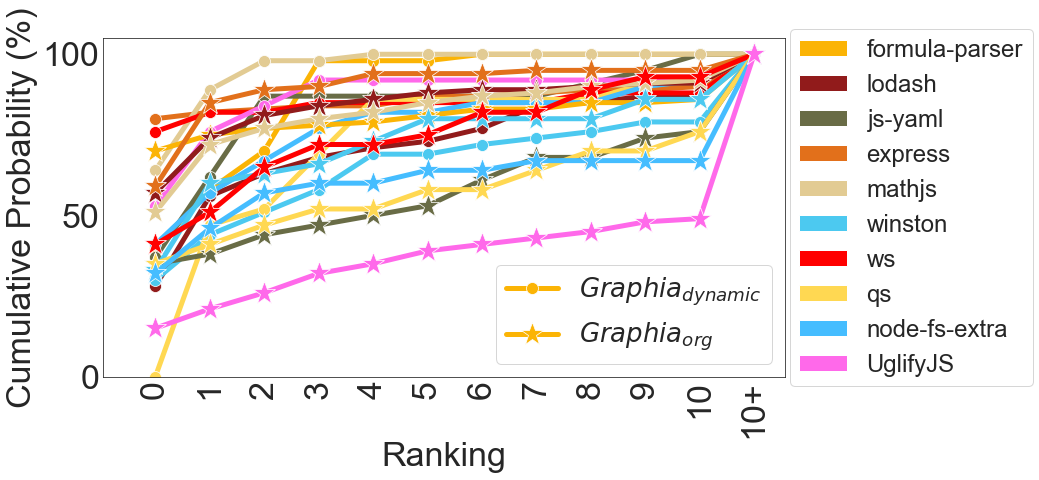

In [182]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.legend_handler import HandlerTuple
warnings.filterwarnings("ignore")
fig, ax1 = plt.subplots()
sns.set_palette("deep")
sns.set_style("white")
line_styles = ['solid', 'dashed', 'dashdot', 'dotted']
# plt.figure(figsize=(10, 4))
# df = pd.DataFrame({'values':values, 'tag':tag})
xticks_list=[]
categories =[x for x in range(rank_count+1)]
for x in range(rank_count+1):
    xticks_list.append(str(x))
xticks_list.append(str(rank_count)+'+')
markers = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D',
           '|', '_', 'd', '8', ',', '.', 'o', 'v', '^', '<', '>']

x = [i for i in range(rank_count+2)]
palette = ["#fbb405", "#911b1b", "#696c46", "#e2701b", "#e2cb93", "#4CC9F0", "#ff0000", "#ffd852", "#45bdff", "#ff69ea", "#38fccf"]
for i in range(len(other_main_list)):
    lst = other_main_list[i]
    sns.lineplot(x,lst, label="$Graphia_{dynamic}$", marker=markers[0], ms= 24, color=palette[i], lw=5, ax=ax1)

for i in range(len(grahia_main_list)):
    lst = grahia_main_list[i]
    sns.lineplot(x,lst, label="$Graphia_{org}$", marker='*', ms= 24, color=palette[i], lw=5, ax=ax1)

ax1.set_xticks(x)
ax1.set_xticklabels(xticks_list, rotation=90)
fs=34
font_size = 24

n=[]        
for i in range(len(app_list)):
    n.append(ax1.bar(0, 0, color=palette[i]))

# l1 = axe.legend(h[1:n_col-1], l[1:n_col-1], loc='upper right', prop={'size':font_size})
if labels is not None:
    l2 = plt.legend(n, app_list, ncol=1, loc='right', bbox_to_anchor=(1.38, .5), prop={'size':font_size}) 
ax1.add_artist(l2)

# # plt.title('Histogram of Candidate Ranking')
ax1.set_xlabel('Ranking', fontsize=fs)
ax1.set_ylabel('Cumulative Probability (%)', fontsize=fs)
ax1.tick_params(axis='both', which='major', pad=0)
ax1.tick_params(axis='y', which='major', labelsize=fs)
ax1.tick_params(axis='x', which='major', labelsize=fs)
handles, labels = plt.gca().get_legend_handles_labels()
# for h in handles: 
#     h.set_linestyle("")

i =1
while i<len(labels):
    if labels[i] in labels[:i]:
        del(labels[i])
        del(handles[i])
    else:
        i +=1
ax1.legend(handles, labels, loc='lower right', ncol=1, numpoints=1, prop={'size':26}, handler_map={tuple: HandlerTuple(ndivide=None)})
plt.rcParams["figure.figsize"] = (12, 5)
plt.tight_layout()
# plt.show()
# plt.savefig("transfer_learning.pdf",bbox_inches='tight', pad_inches=0, transparent=True)
plt.subplots_adjust(left=0.2, right=0.99, top=0.99, bottom=0.05)
plt.savefig("candidate_figures/comparison_dynamic.pdf", bbox_inches='tight', pad_inches=0, transparent=True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
x = np.linspace(0, 10, 100)
y = np.sin(x[:, None] + np.pi * np.arange(0, 2, 0.1))

# Plotting the lines
fig, ax = plt.subplots()

# First group of lines
for i in range(9):
    ax.plot(x, y[:, i], label=f'Group 1, Line {i+1}')

# Second group of lines
for i in range(9, 18):
    ax.plot(x, y[:, i], label=f'Group 2, Line {i-8}', linestyle='--')

# Creating two legends
legend1 = plt.legend(handles=ax.lines[:9], loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol = 5, title='Group 1')
legend2 = plt.legend(handles=ax.lines[9:], loc='lower right', title='Group 2')

# Adding the first legend manually to the plot
ax.add_artist(legend1)

plt.show()


In [ ]:
for i in range(len(grahia_main_list)):
    lst = grahia_main_list[i]
    lst1 = other_main_list[i]
    print(lst1[0]-lst[0])

In [162]:
from cmath import nan
def add_dummy_nodes(nodes_data):
    stmt_type=['Identifier']
    nodes_data = nodes_data[nodes_data.type.isin(stmt_type)]
    nodes_data = nodes_data.replace({'name': 'undefined'}, nan)
    nodes_data = nodes_data.dropna(subset=['name'])
    df_name_list = nodes_data['name'].tolist()
    
    temp_node_df = pd.DataFrame(columns=nodes_data.columns)
    temp_edge_df = pd.DataFrame(columns=['src','dst'], dtype='int64')
    global_id = 0
    for name in set(df_name_list):
        df2 = pd.DataFrame([[int(global_id), "special", name, -1, -1, int(global_id)]], columns=nodes_data.columns)
        temp_node_df = pd.concat([temp_node_df, df2], ignore_index=True)
        t_df = nodes_data[nodes_data['name']==name]
        ids = t_df['new_id'].tolist()

        for id_ in ids:
            df2 = pd.DataFrame([[int(id_), int(global_id)]], columns=['src','dst'],dtype='int64')
            temp_edge_df = pd.concat([temp_edge_df, df2], ignore_index=True)

        global_id+=1
        
    return temp_node_df, temp_edge_df
app_list =  ['lodash', 'underscore', 'eslint-plugin-import', 'mocha', 'angular', 'ramda', 'shelljs', 'js-yaml', 'bluebird', 'express', 'async', 'jsPDF', 'jquery', 
             'coffeescript', 'handlebars.js', 'bootstrap', 'immutable-js', 'package', 'q', 'formula-parser', 'atompm', 'request', 'mongoose', 'mathjs', 'less.js', 'webpack', 
             'eslint-plugin-react', 'axios', 'react', 'chai', 'autoprefixer', 'winston', 'node-semver', 'html-webpack-plugin', 'qs', 'chokidar', 'postcss', 'ejs', 
             'morgan', 'mysql', 'Inquirer.js', 'jest', 'rxjs', 'node-fs-extra', 'socket.io', 'joi','node-jsonwebtoken','UglifyJS','ws','create-react-app']
        
ROOT_PATH = "../prune_new/"
edge_lst = []
for APPLICATION_NAME in app_list:
    df = pd.read_csv(ROOT_PATH+ APPLICATION_NAME+'_node.csv')
    nodes_data = df.drop(["start_line","start_column","end_line",  "end_column" ,"file_name"], axis=1)
    dummy_nodes, dummy_edge = add_dummy_nodes(nodes_data)
    print(APPLICATION_NAME, " New node ====> ", len(dummy_nodes), " New edge======> ", len(dummy_edge))
    edge_lst.append(len(dummy_edge))

lodash  New node ====>  1449  New edge======>  10801
underscore  New node ====>  1788  New edge======>  5840
eslint-plugin-import  New node ====>  1435  New edge======>  4936
mocha  New node ====>  1787  New edge======>  7766
angular  New node ====>  2725  New edge======>  11803
ramda  New node ====>  1848  New edge======>  9929
shelljs  New node ====>  713  New edge======>  2802
js-yaml  New node ====>  977  New edge======>  3421
bluebird  New node ====>  3174  New edge======>  11848
express  New node ====>  665  New edge======>  4032
async  New node ====>  1438  New edge======>  6295
jsPDF  New node ====>  14802  New edge======>  36207
jquery  New node ====>  2714  New edge======>  8608
coffeescript  New node ====>  3284  New edge======>  15695
handlebars.js  New node ====>  1402  New edge======>  3641
bootstrap  New node ====>  1588  New edge======>  5582
immutable-js  New node ====>  987  New edge======>  2418
package  New node ====>  1881  New edge======>  4094
q  New node ====>  

In [165]:
from statistics import median
def format(num):
    if num > 1000000:
        if not num % 1000000:
            return f'€{num // 1000000}M'
        return f'€{round(num / 1000000, 1)}M'
    return f'€{num // 1000}K'
print((np.mean(edge_lst))," ==> ", format(np.sum(edge_lst)), min(edge_lst), format(max(edge_lst)), median(edge_lst), format(np.median(edge_lst)))

7732.08  ==>  €386K 237 €54K 4063.0 €4.0K
